In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_csv('final_combined_dataset.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1,-2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[4, 5, 6])
data = data.dropna().reset_index(drop=True)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False), ['geocode'])  # One-hot encode 'geocode'
], remainder='passthrough')  # Keep all other columns as is

transformed_data = ct.fit_transform(data)

# Get feature names
feature_names = ct.get_feature_names_out()

# Clean feature names to remove 'remainder__' prefix
cleaned_feature_names = [name.split('__')[-1] if 'remainder__' in name else name for name in feature_names]

# Convert transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=cleaned_feature_names)

numeric_cols = data.select_dtypes(include=['float64', 'int64','int32']).columns
for col in numeric_cols:
    if col in transformed_df.columns:
        transformed_df[col] = pd.to_numeric(transformed_df[col], errors='coerce')

if 'date' in transformed_df.columns:
    transformed_df['date'] = pd.to_datetime(transformed_df['date'], errors='coerce')

data= transformed_df

# Now 'transformed_df' contains the transformed data with the correct types
train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]
pd.set_option('display.max_columns', None)
train_data


onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51399                     0.0                     0.0                     0.0   
51400                     0.0                     0.0                     0.0   
51401                     0.0                     0.0                     0.0   
51402                     0.0                     0.0                     0.0   
51403                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51399                     0.0                     0.0                     0.0   
51400                     0.0                     0.0                     0.0   
51401                     0.0                     0.0                     0.0   
51402                     0.0                     0.0                     0.0   
51403                     0.0                     0.0                     0.0   

      onehot__geocode_3300308 onehot__geocode_3300407 onehot__geocode_3300456  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51399                     0.0                     0.0                     0.0   
51400                     0.0                     0.0                     0.0   
51401                     0.0                     0.0                     0.0   
51402                     0.0                     0.0                     0.0   
51403                     0.0                     0.0                     0.0   

      onehot__geocode_3300506 onehot__geocode_3300605 onehot__geocode_3300704  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51399                     0.0                     0.0                     0.0   
51400                     0.0                     0.0                     0.0   
51401                     0.0                     0.0                     0.0   
51402                     0.0                     0.0                     0.0   
51403                     0.0                     0.0                     0.0   

      onehot__geocode_3300803 onehot__geocode_3300902 onehot__geocode_3300936  \
0                         0.0    

In [4]:
X_train = train_data.drop(columns=['cases','cases_per_100k','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_per_100k','cases_lag-2'])
y_test = test_data[['cases_lag-2']]

data = data.drop(columns=['cases_per_100k'])

data

onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51501                     0.0                     0.0                     0.0   
51502                     0.0                     0.0                     0.0   
51503                     0.0                     0.0                     0.0   
51504                     0.0                     0.0                     0.0   
51505                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51501                     0.0                     0.0                     0.0   
51502                     0.0                     0.0                     0.0   
51503                     0.0                     0.0                     0.0   
51504                     0.0                     0.0                     0.0   
51505                     0.0                     0.0                     0.0   

      onehot__geocode_3300308 onehot__geocode_3300407 onehot__geocode_3300456  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51501                     0.0                     0.0                     0.0   
51502                     0.0                     0.0                     0.0   
51503                     0.0                     0.0                     0.0   
51504                     0.0                     0.0                     0.0   
51505                     0.0                     0.0                     0.0   

      onehot__geocode_3300506 onehot__geocode_3300605 onehot__geocode_3300704  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51501                     0.0                     0.0                     0.0   
51502                     0.0                     0.0                     0.0   
51503                     0.0                     0.0                     0.0   
51504                     0.0                     0.0                     0.0   
51505                     0.0                     0.0                     0.0   

      onehot__geocode_3300803 onehot__geocode_3300902 onehot__geocode_3300936  \
0                         0.0    

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV

# Step 1-6: Keep the previous preprocessing steps the same (data preparation, scaling, etc.)
columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]

feature_cols = [
    'cases_lag0', 'cases_lag1',
    'temp_avg_lag4', 'humidity_avg_lag4',
    'precipitation_max_regression_kriging_lag4',
    'week_sin', 'month_sin', 'week_cos', 'month_cos',
    'year_sin', 'year_cos','week'
]

selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and col not in columns_not_to_scale]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

X_train

cases_lag0  cases_lag1  temp_avg_lag4  humidity_avg_lag4  \
0        0.002516    0.002652       0.676283           0.164814   
1        0.002244    0.002516       0.696355           0.134769   
2        0.003128    0.002244       0.744210           0.076346   
3        0.002856    0.003128       0.857288           0.030776   
4        0.002584    0.002856       0.735651           0.112676   
...           ...         ...            ...                ...   
51399    0.000204    0.000068       0.517630           0.248426   
51400    0.000068    0.000204       0.657278           0.283328   
51401    0.000000    0.000068       0.633257           0.278037   
51402    0.000136    0.000000       0.701750           0.224499   
51403    0.000000    0.000136       0.637623           0.265076   

       precipitation_max_regression_kriging_lag4  week_sin     month_sin  \
0                                       0.050450  0.748511  8.660254e-01   
1                                       0.084866  0.663123  8.660254e-01   
2                                       0.126653  0.568065  8.660254e-01   
3                                       0.418930  0.464723  1.000000e+00   
4                                       0.466587  0.354605  1.000000e+00   
...                                          ...       ...           ...   
51399                                   0.065320 -0.354605 -5.000000e-01   
51400                                   0.279291 -0.464723 -2.449294e-16   
51401                                   0.247231 -0.568065 -2.449294e-16   
51402                                   0.129773 -0.663123 -2.449294e-16   
51403                                   0.172175 -0.748511 -2.449294e-16   

       week_cos     month_cos  year_sin  year_cos    week  \
0     -0.663123  5.000000e-01 -0.031069  0.999517  201207   
1     -0.748511  5.000000e-01 -0.031069  0.999517  201208   
2     -0.822984  5.000000e-01 -0.031069  0.999517  201209   
3     -0.885456  6.123234e-17 -0.031069  0.999517  201210   
4     -0.935016  6.123234e-17 -0.031069  0.999517  201211   
...         ...           ...       ...       ...     ...   
51399 -0.935016  8.660254e-01 -0.006215  0.999981  202049   
51400 -0.885456  1.000000e+00 -0.006215  0.999981  202050   
51401 -0.822984  1.000000e+00 -0.006215  0.999981  202051   
51402 -0.748511  1.000000e+00 -0.006215  0.999981  202052   
51403 -0.663123  1.000000e+00 -0.006215  0.999981  202053   

      onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51399                     0.0                     0.0                     0.0   
51400                     0.0                     0.0                     0.0   
51401                     0.0                     0.0                     0.0   
51402                     0.0                     0.0                     0.0   
51403                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51399           

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Train RMSE: 49.32925103997619
Test RMSE: 6.6853247348619895
Train R²: 0.9540482519394549
Test R²: 0.8173435353117018
Mean Absolute Error (MAE): 1.7068440940836676
Mean Absolute Percentage Error (MAPE): 1.5510165849497498e+17 %


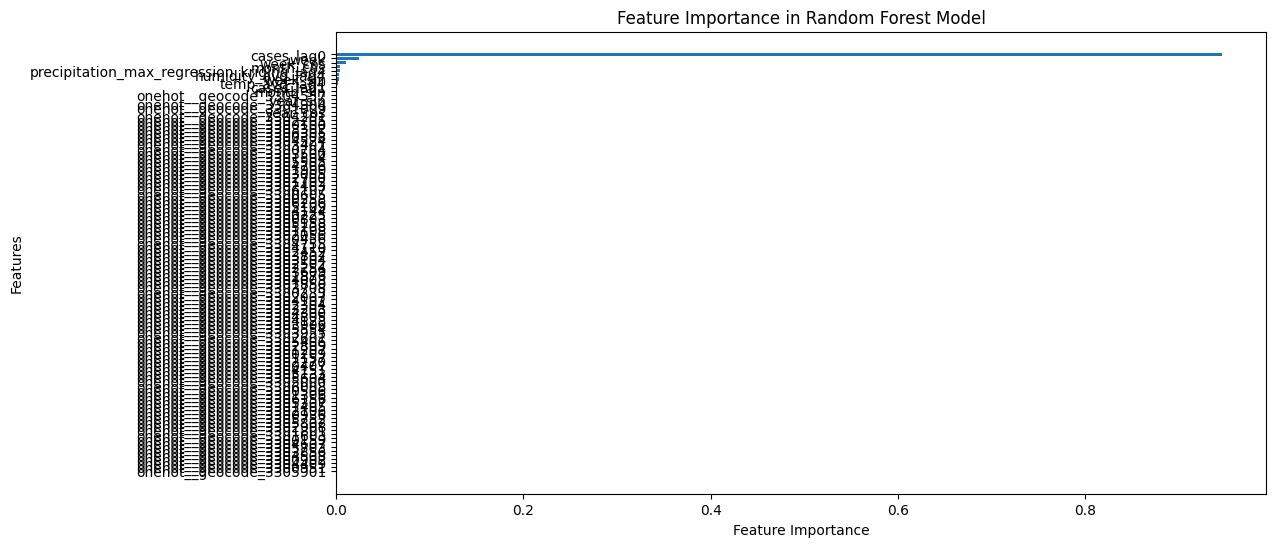

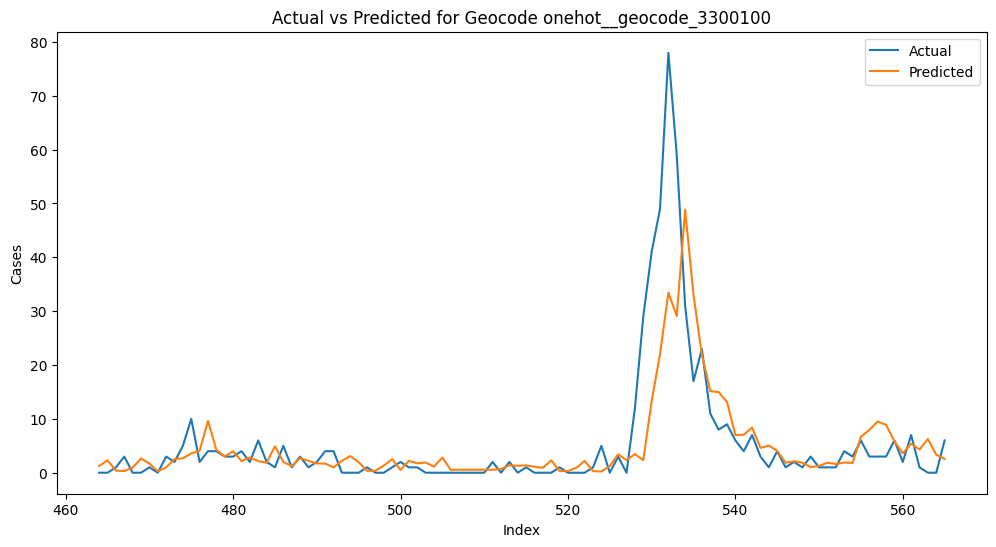

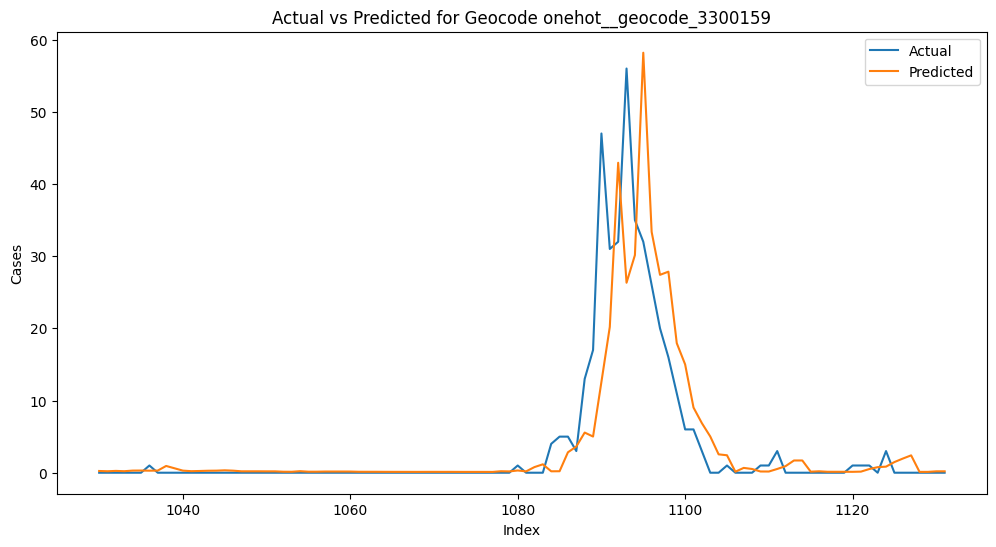

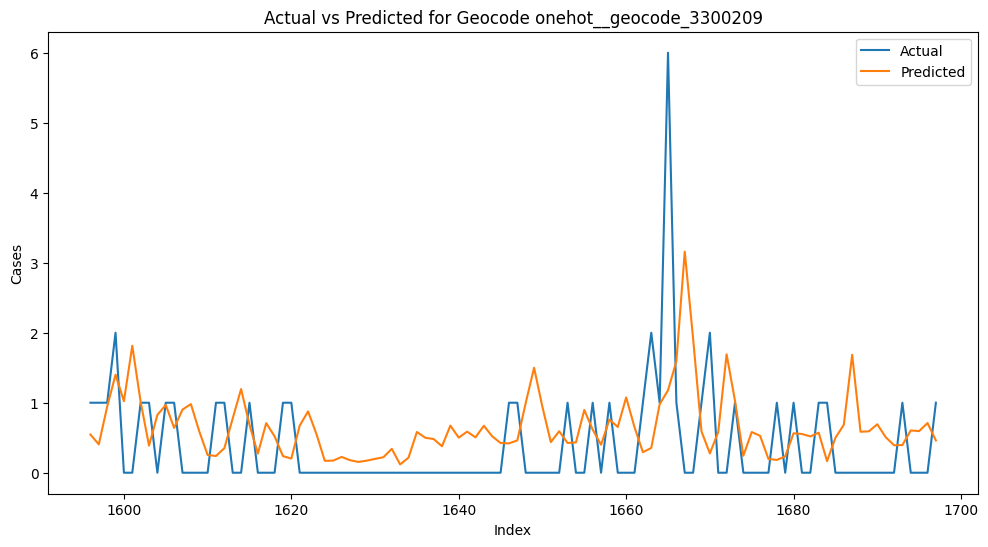

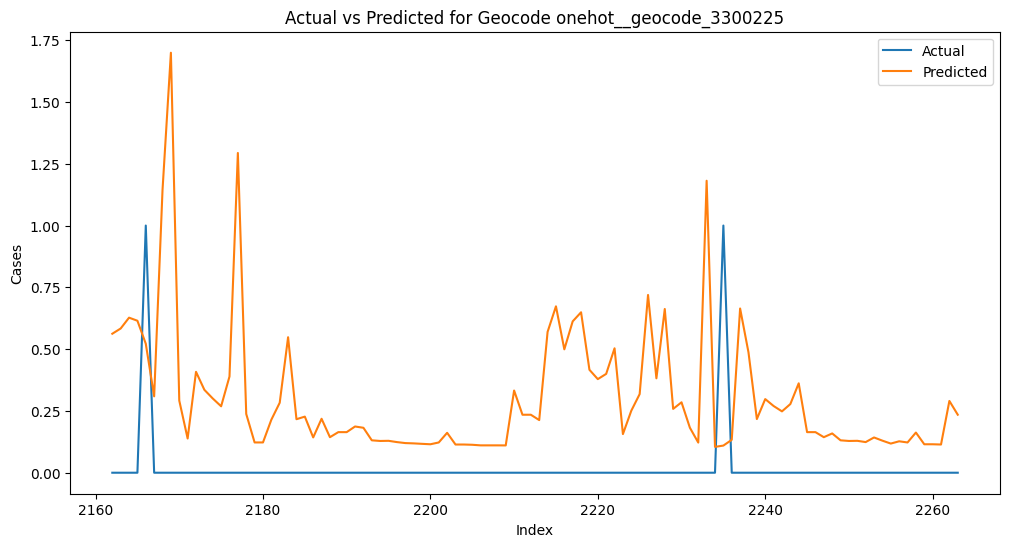

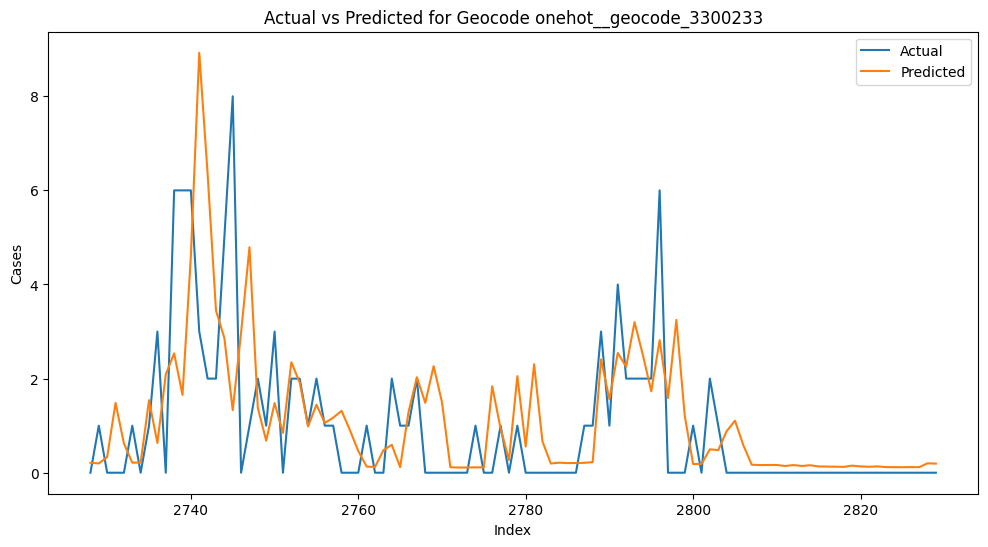

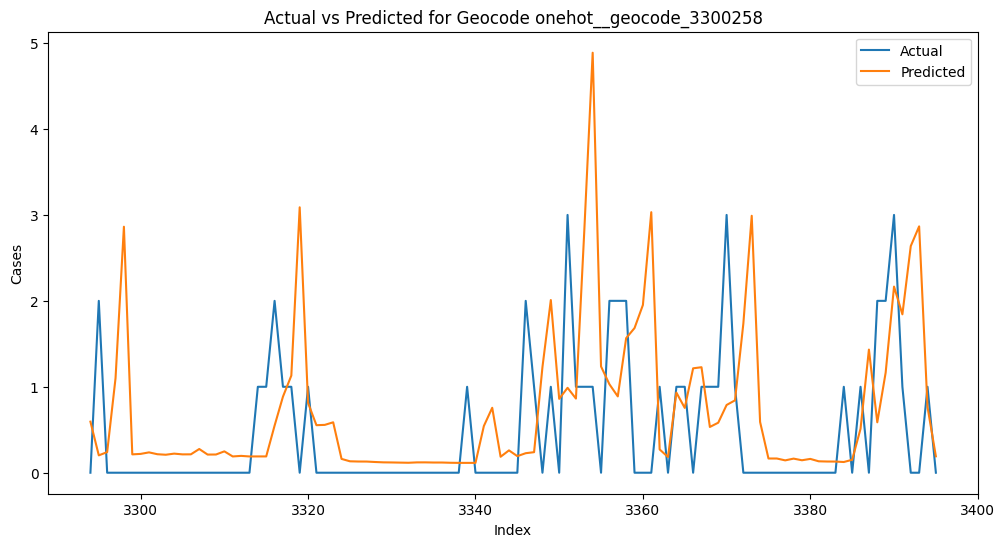

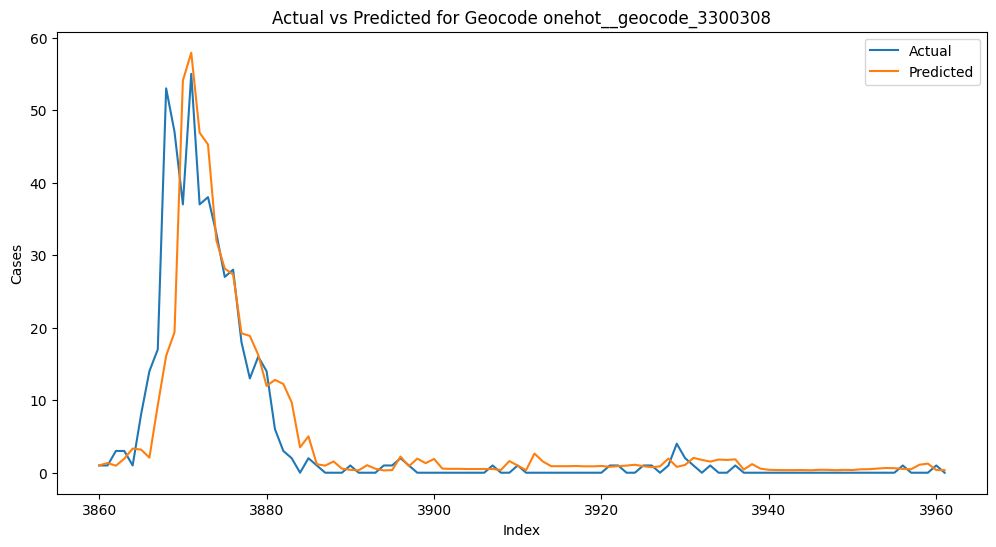

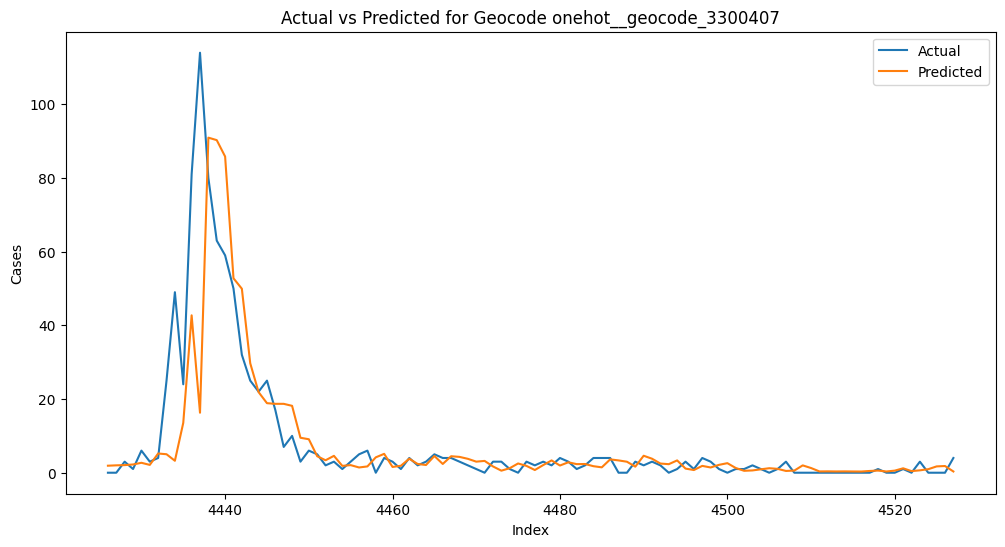

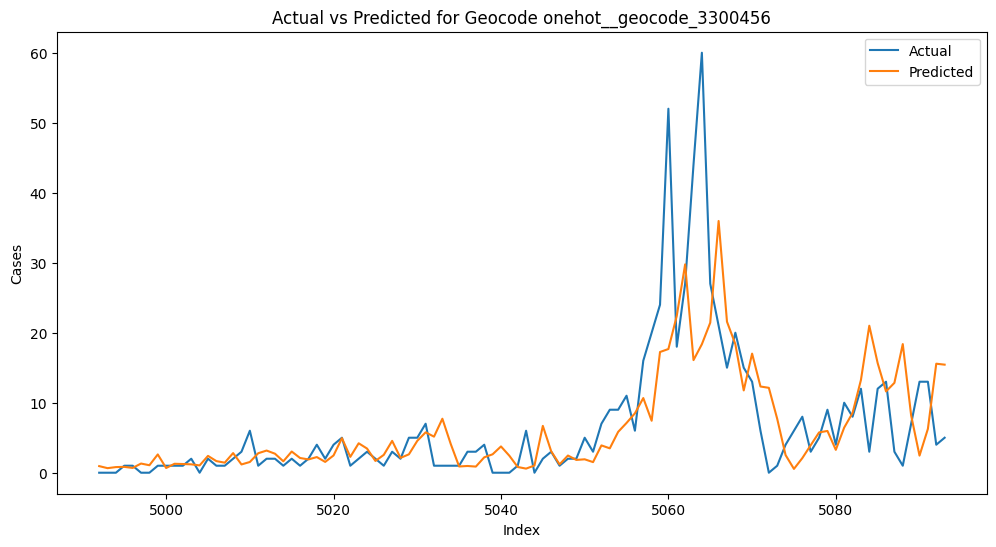

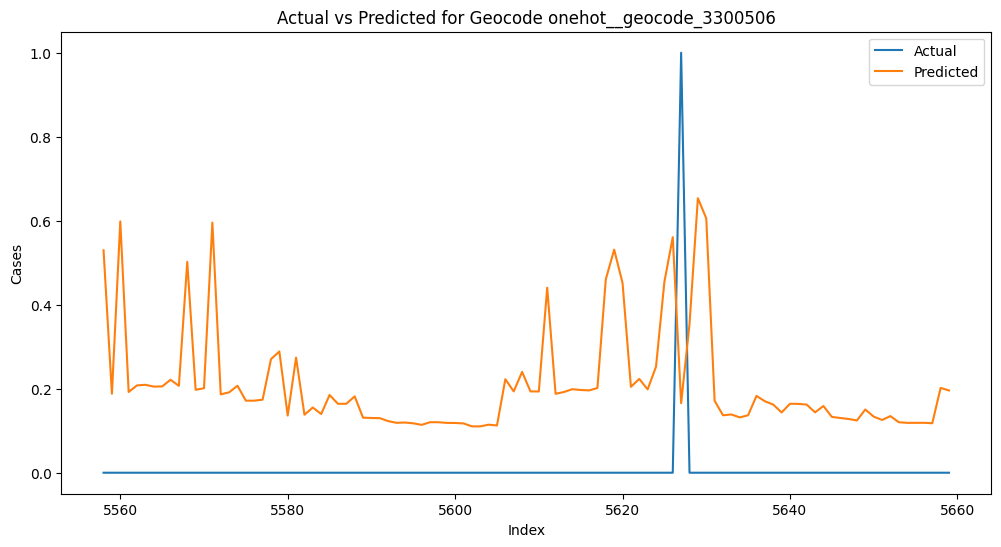

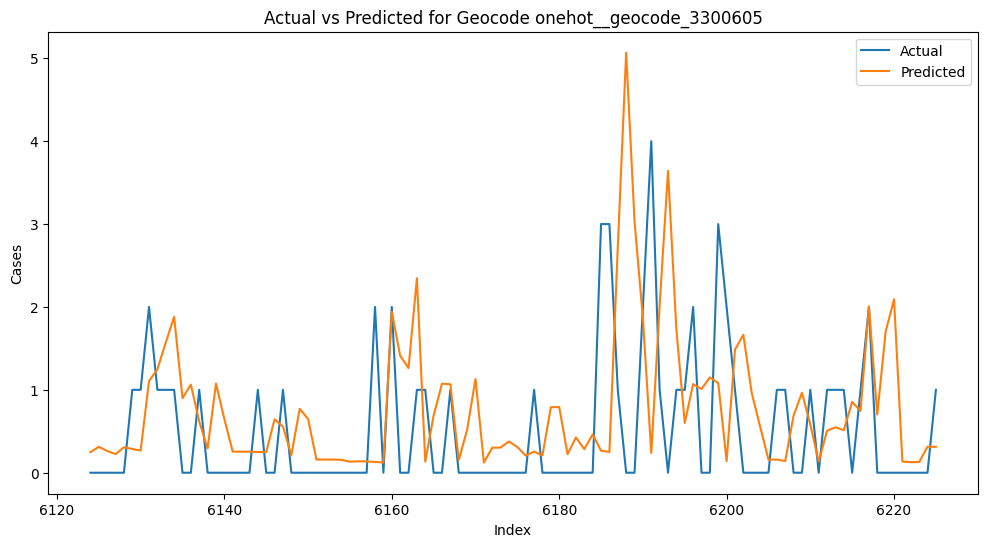

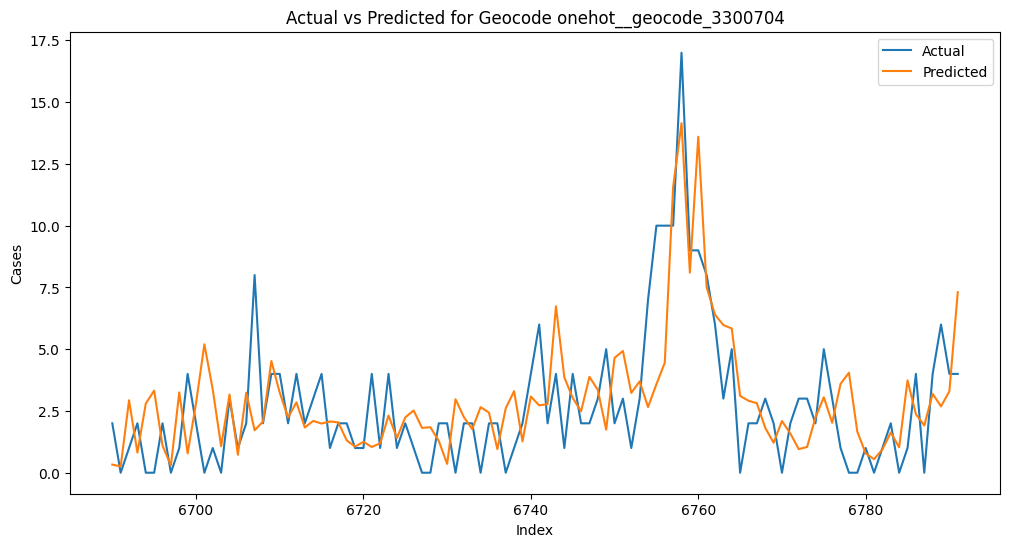

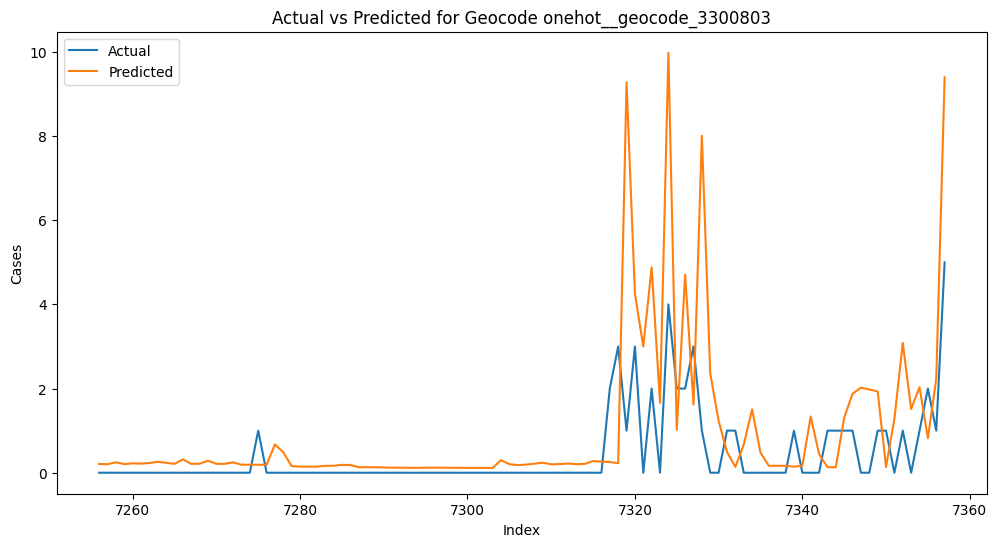

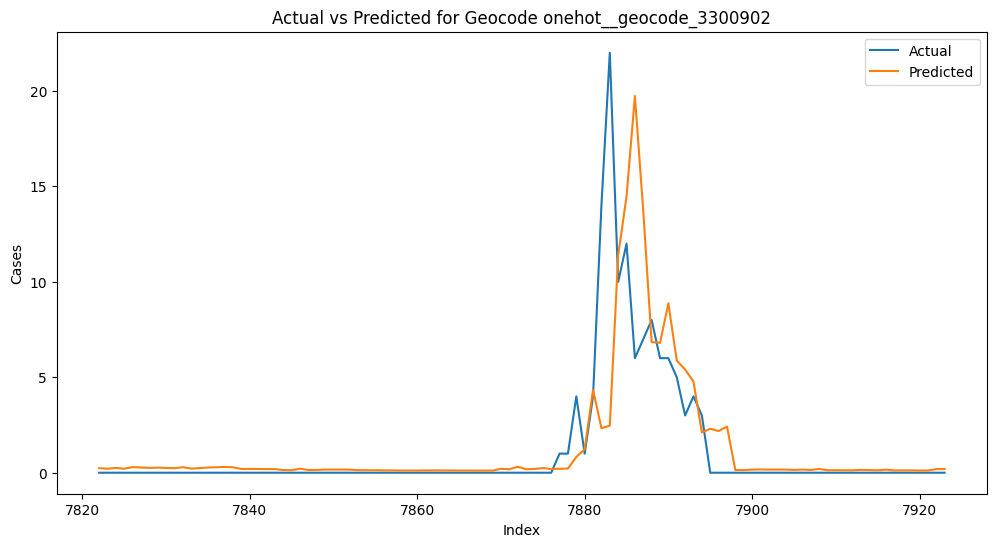

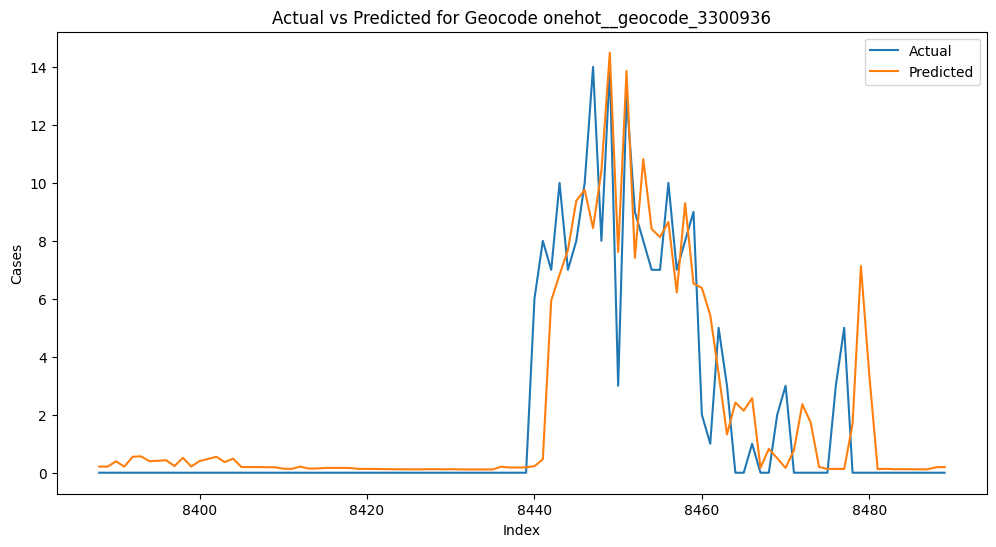

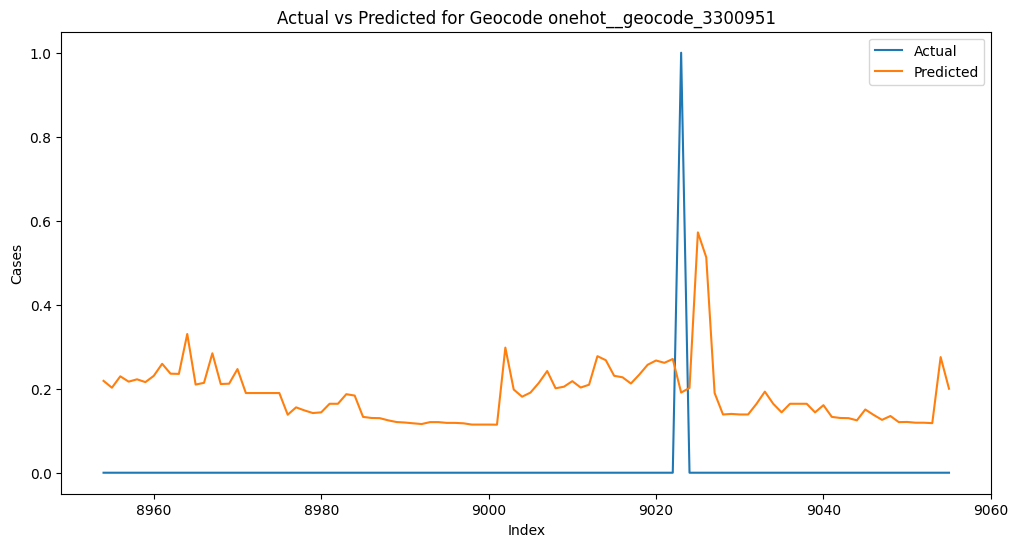

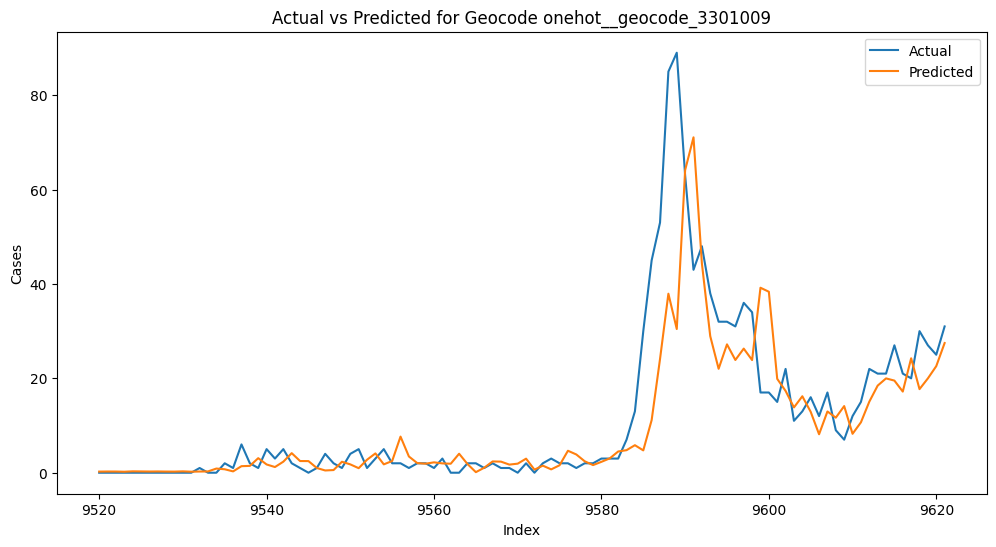

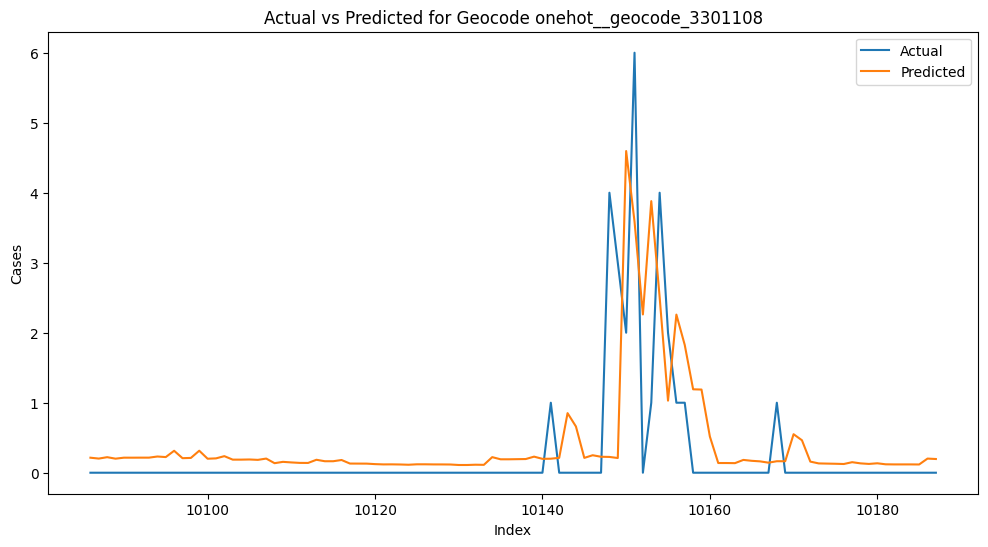

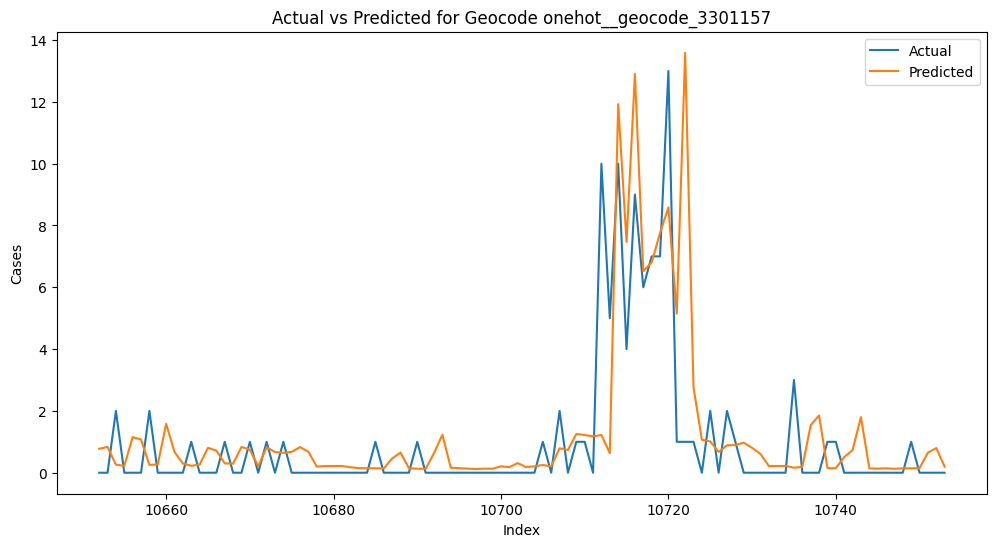

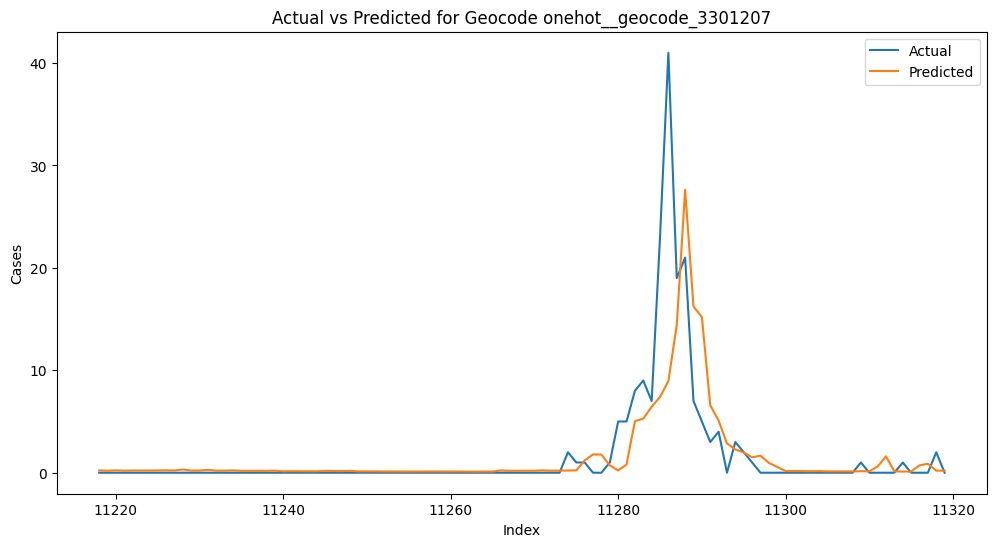

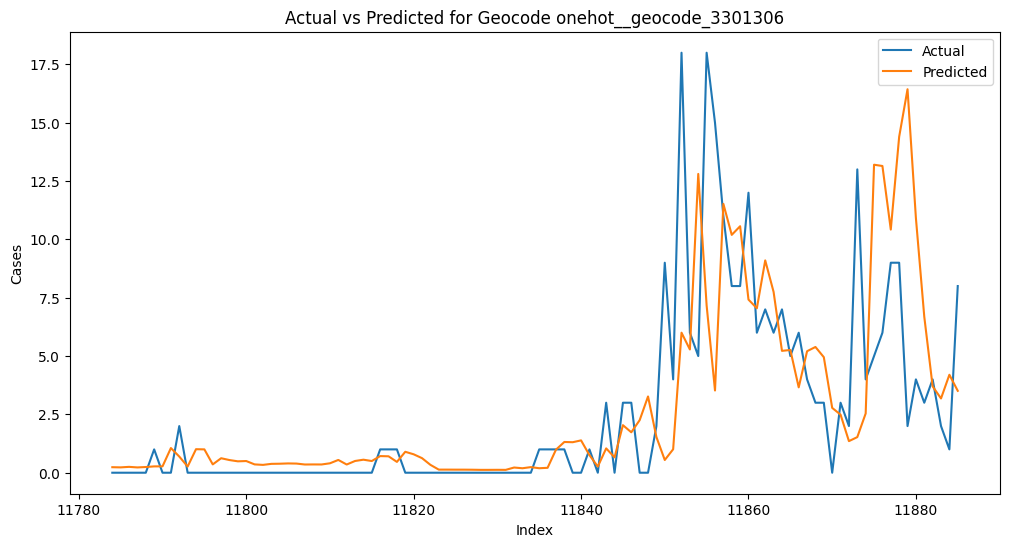

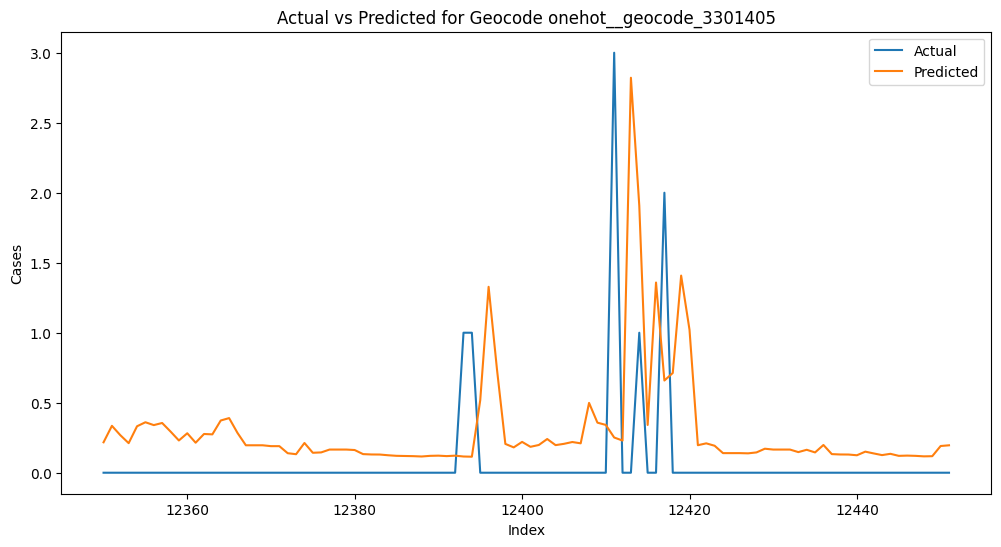

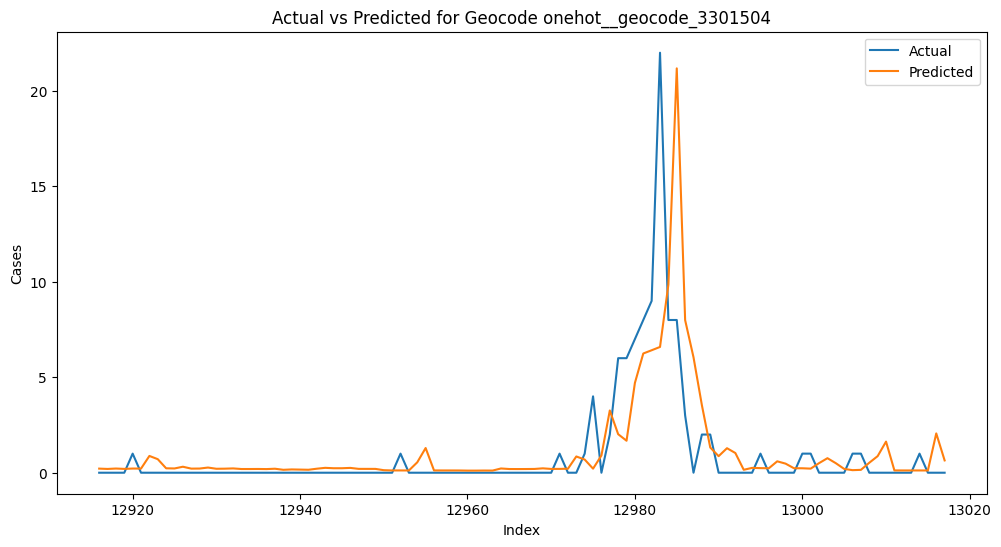

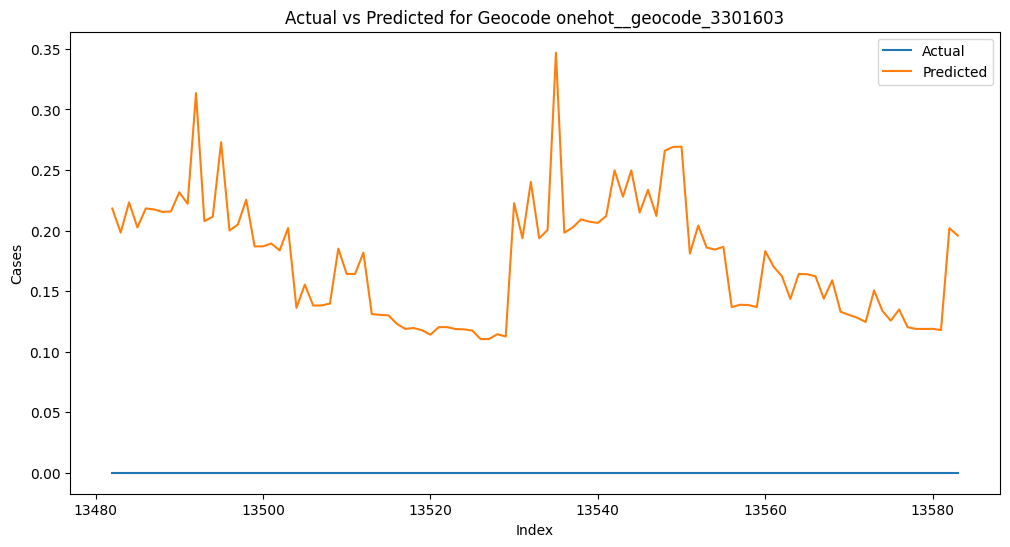

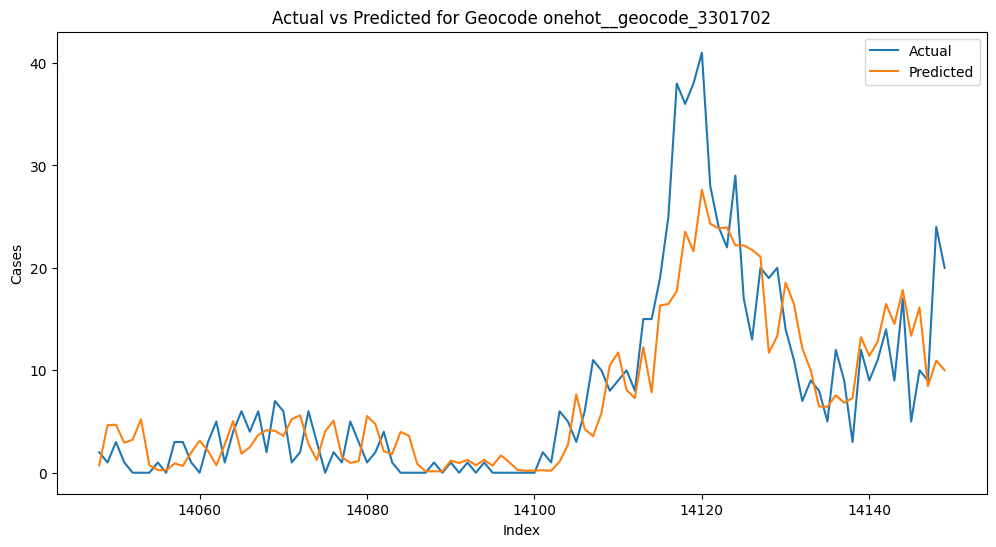

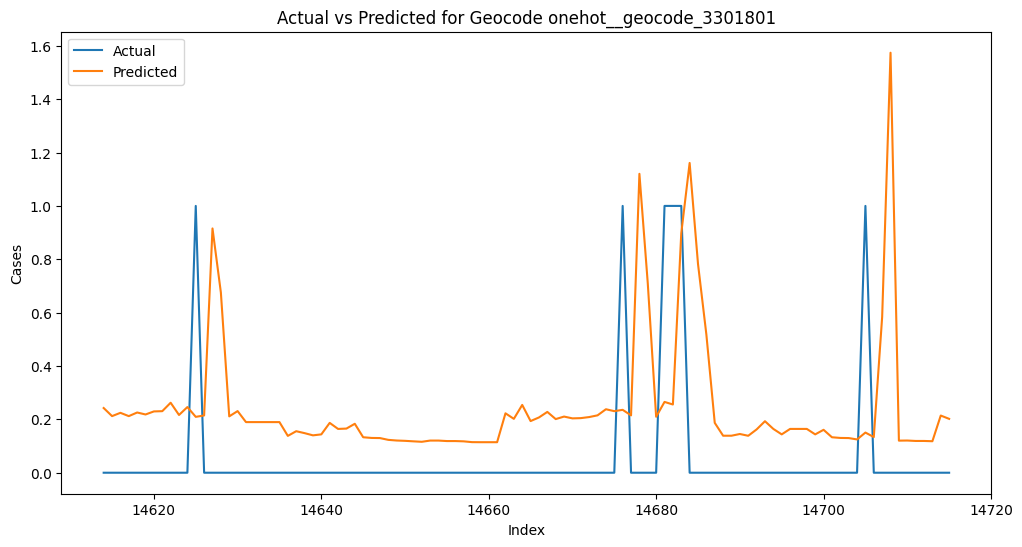

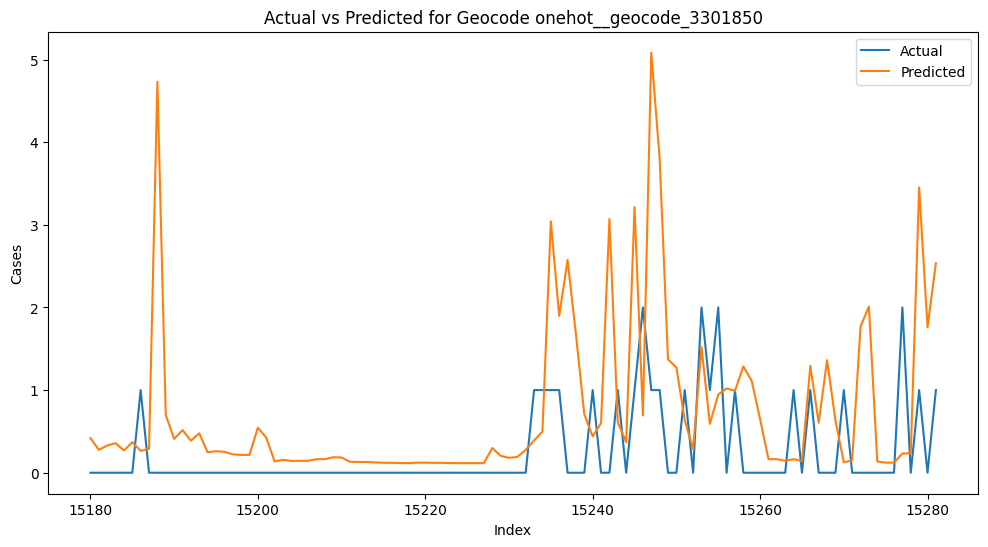

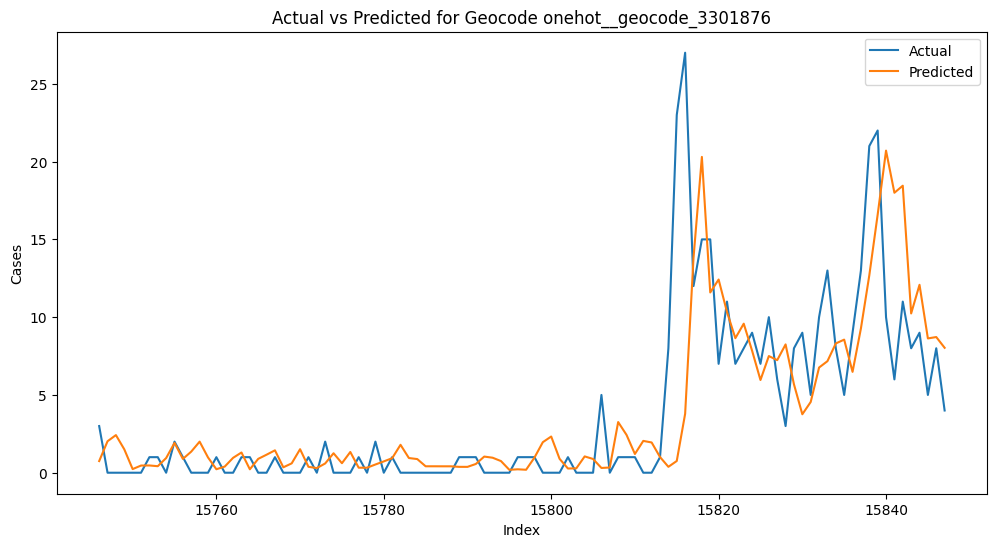

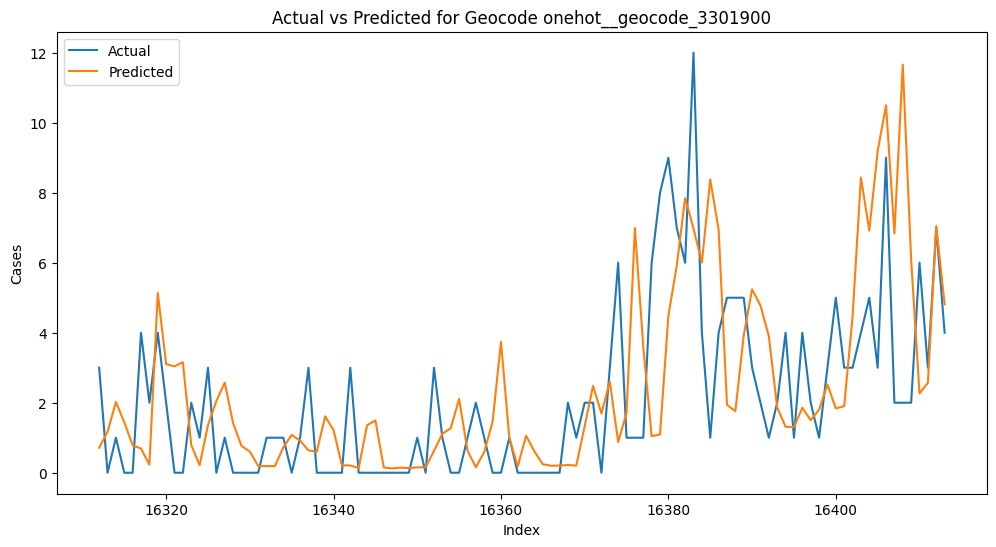

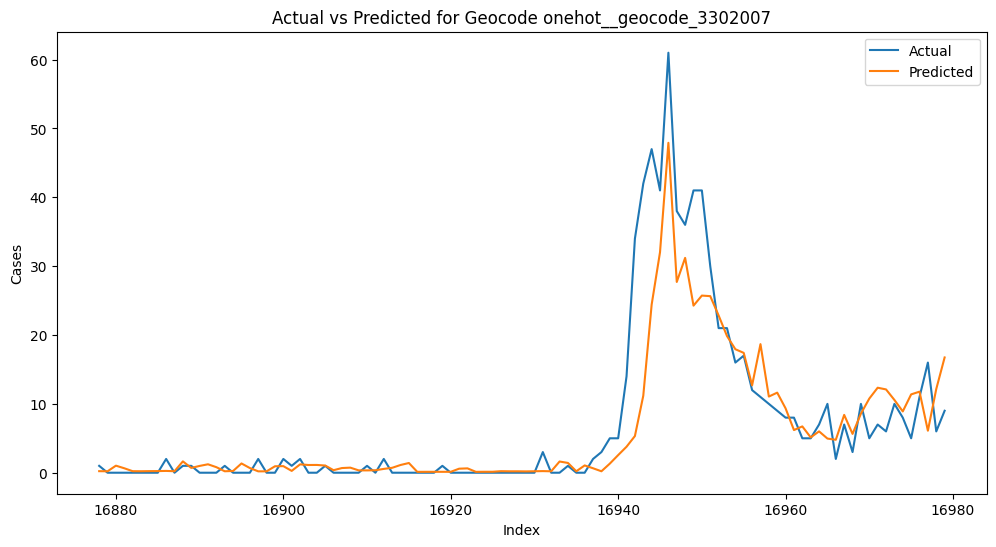

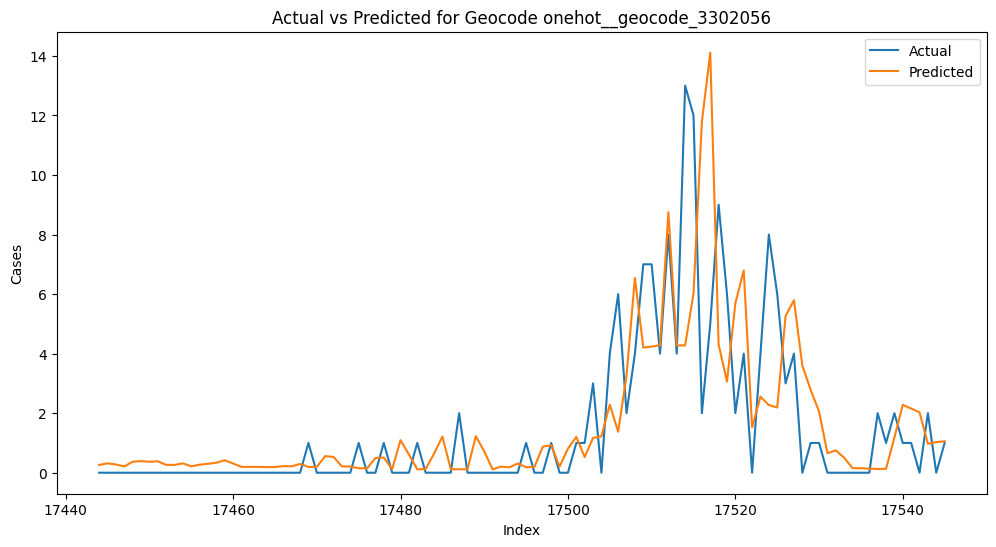

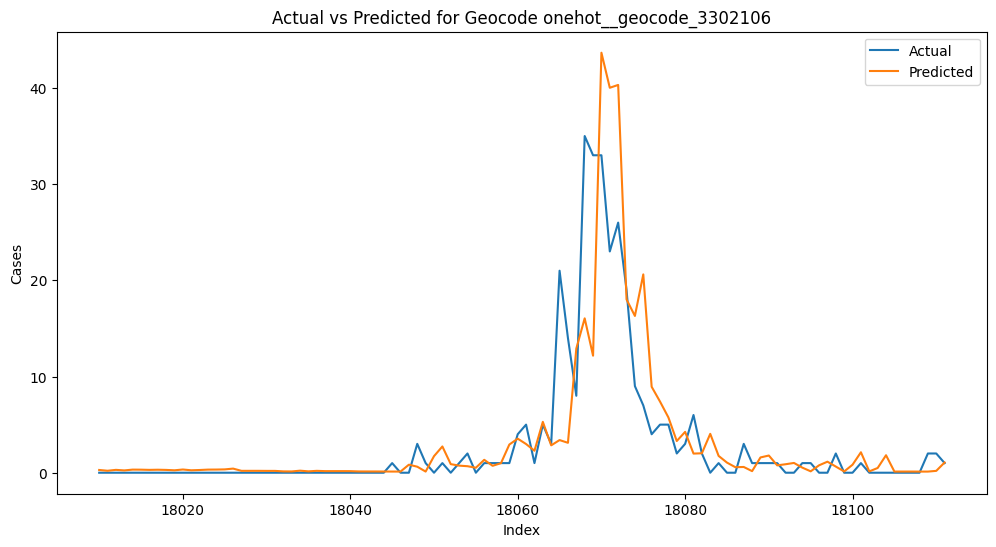

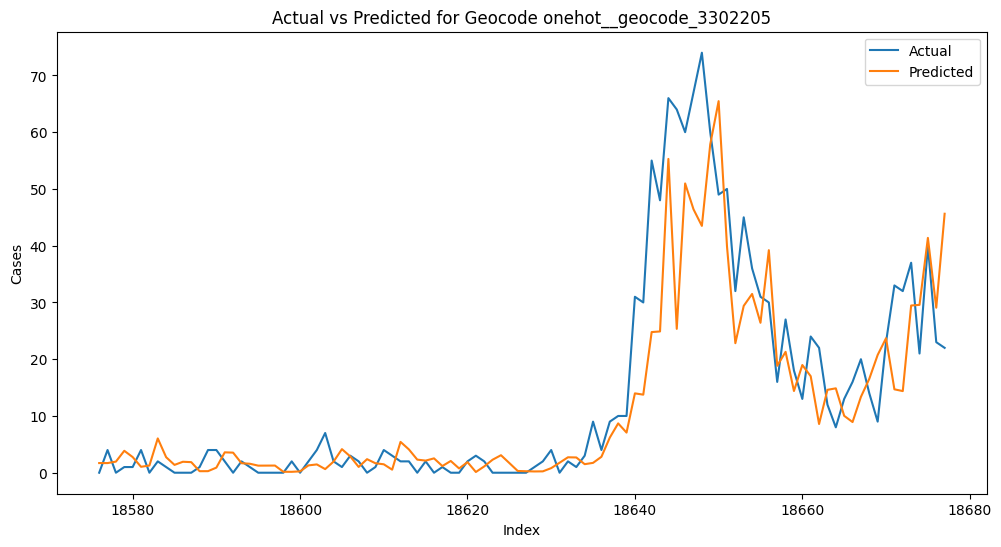

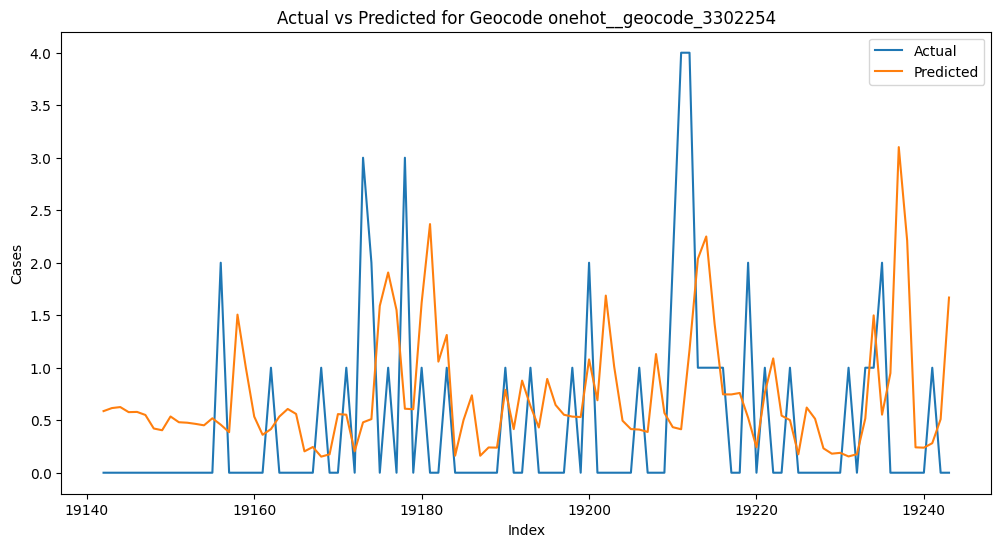

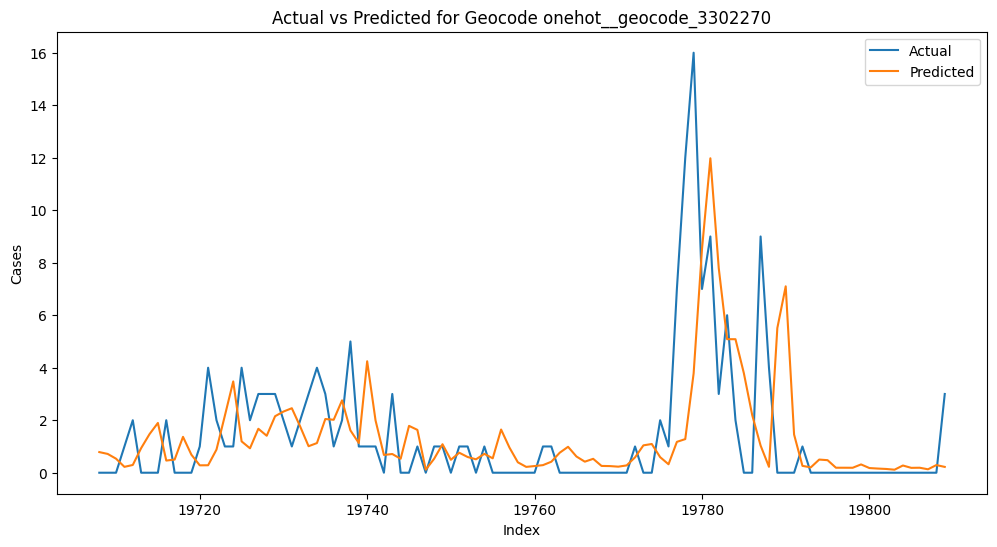

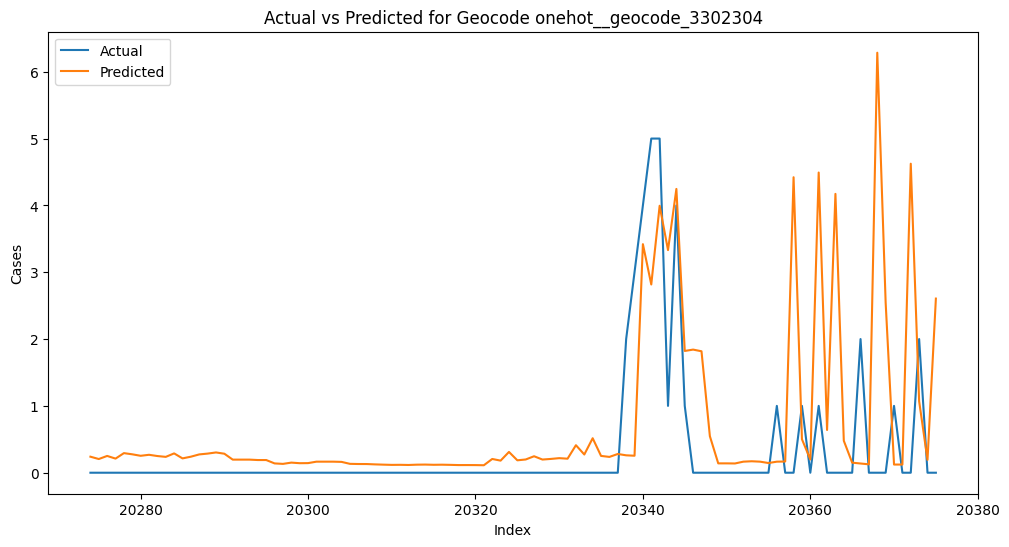

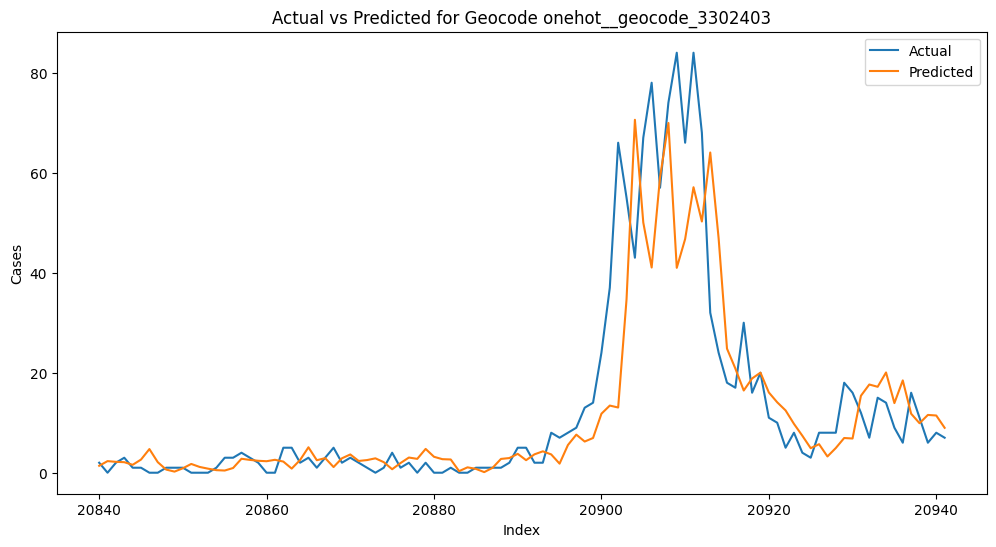

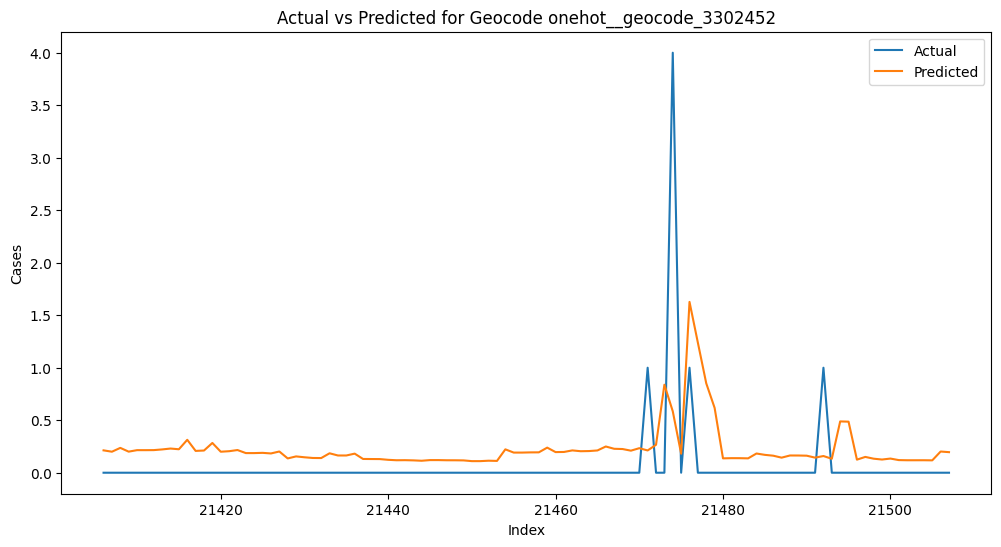

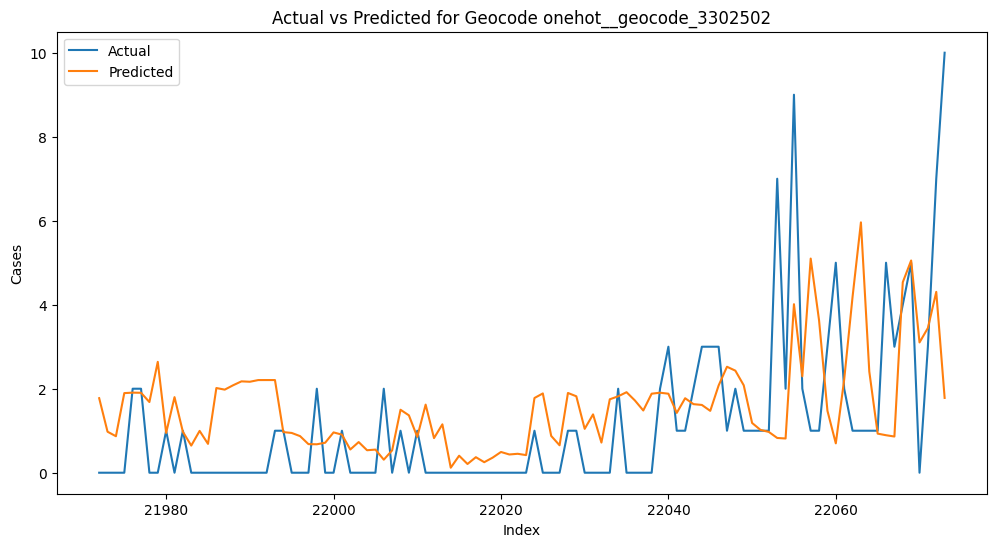

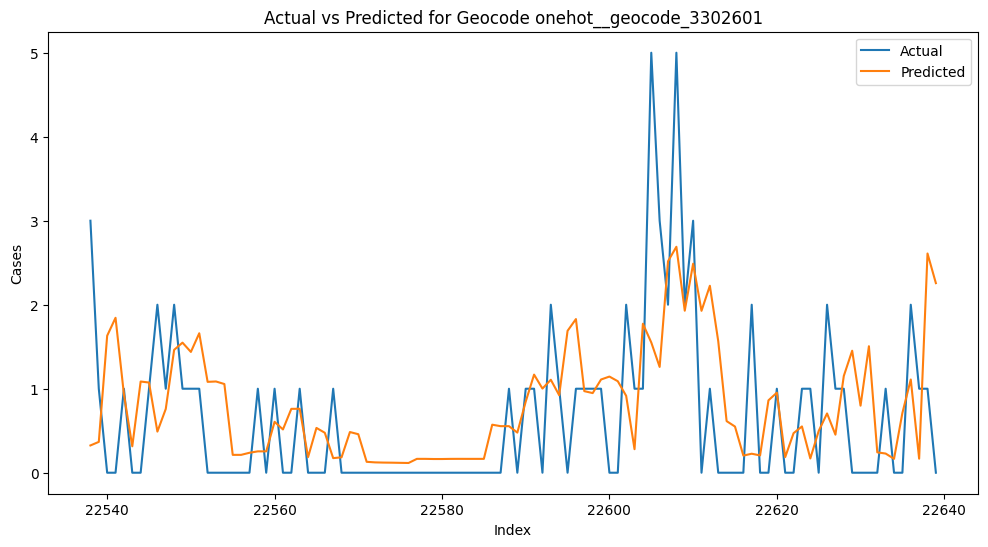

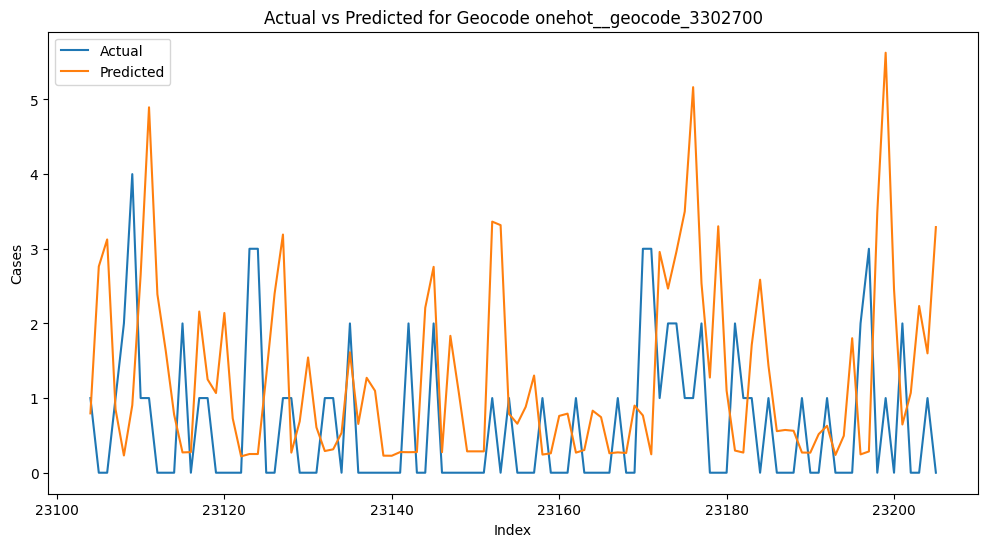

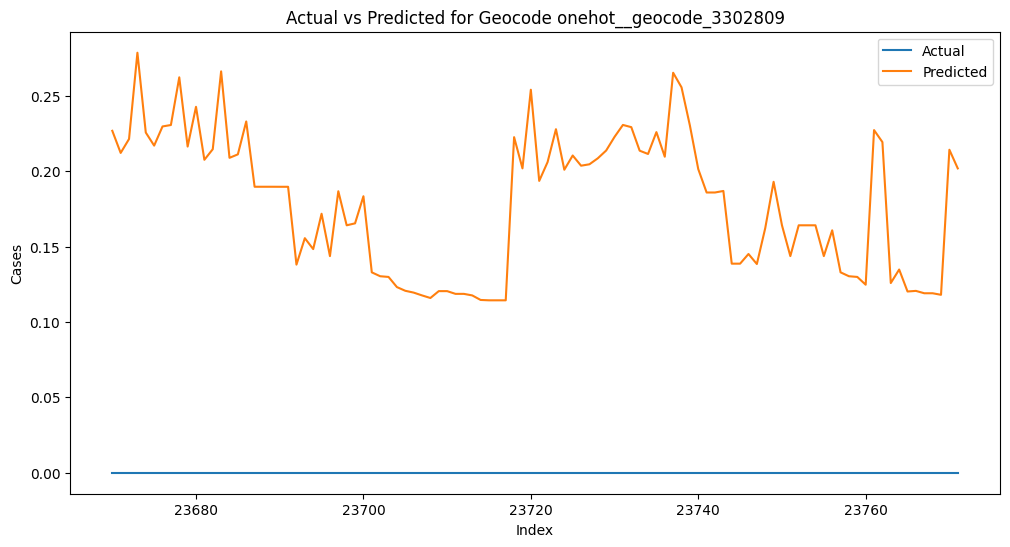

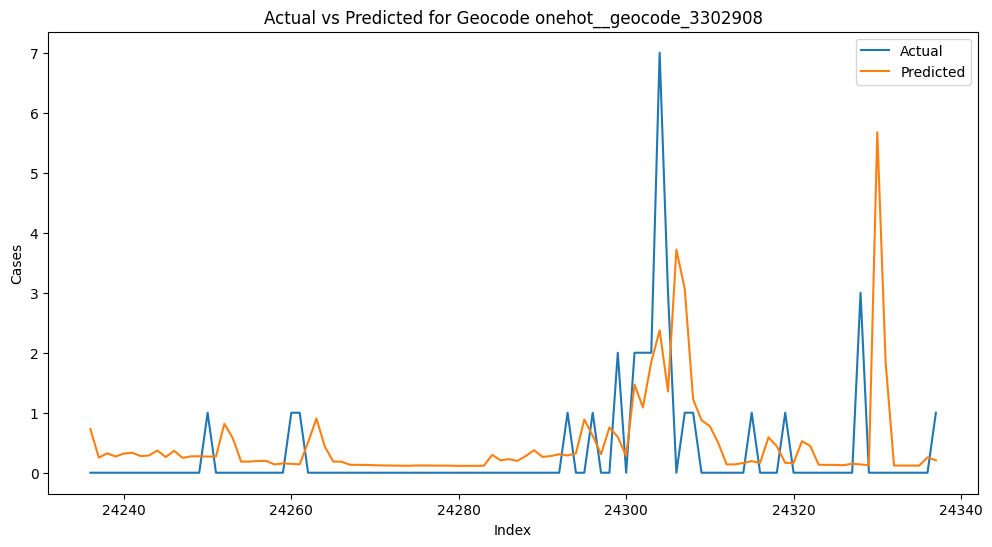

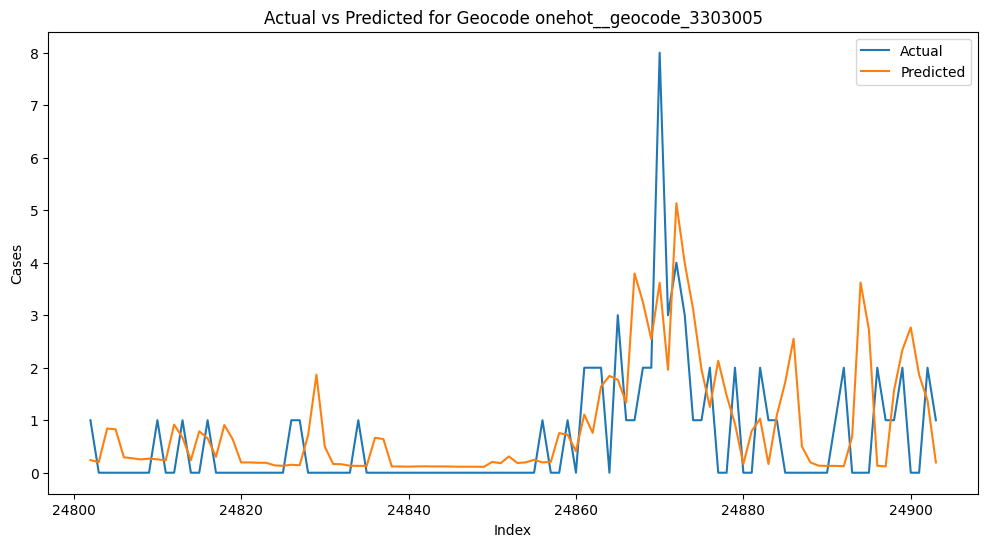

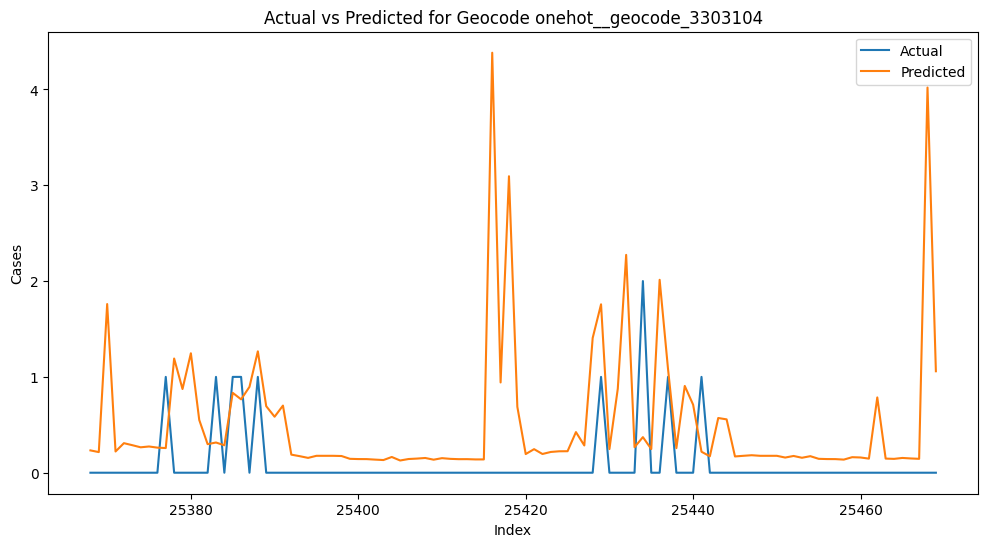

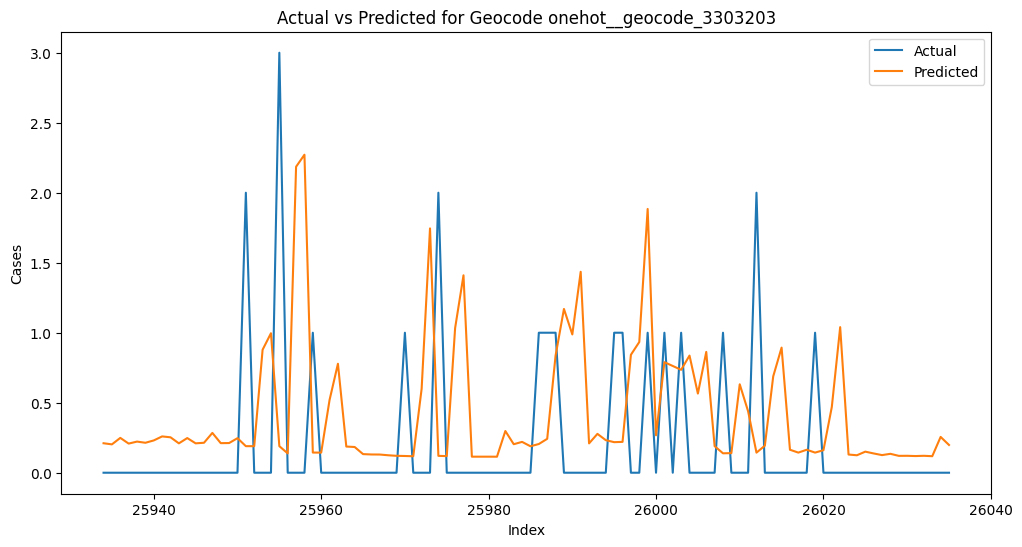

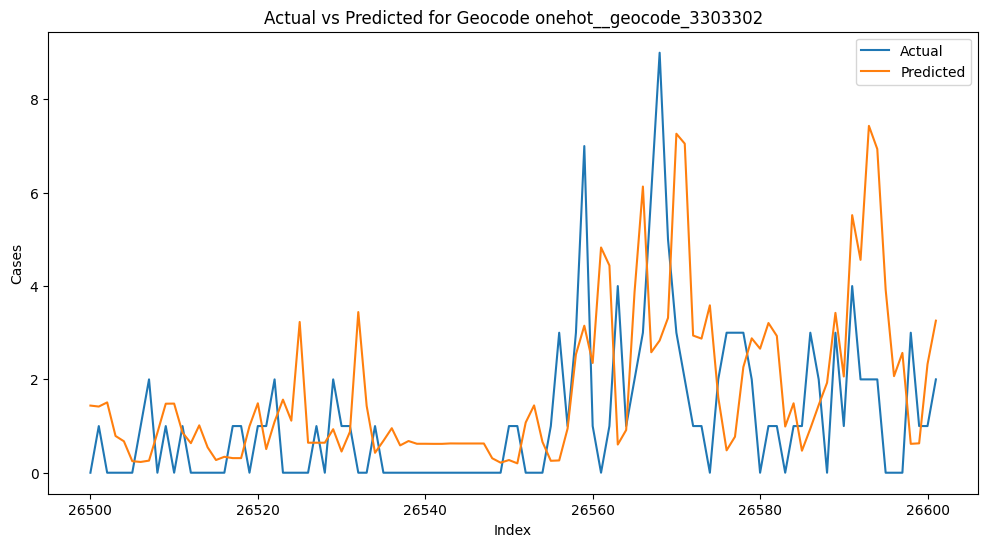

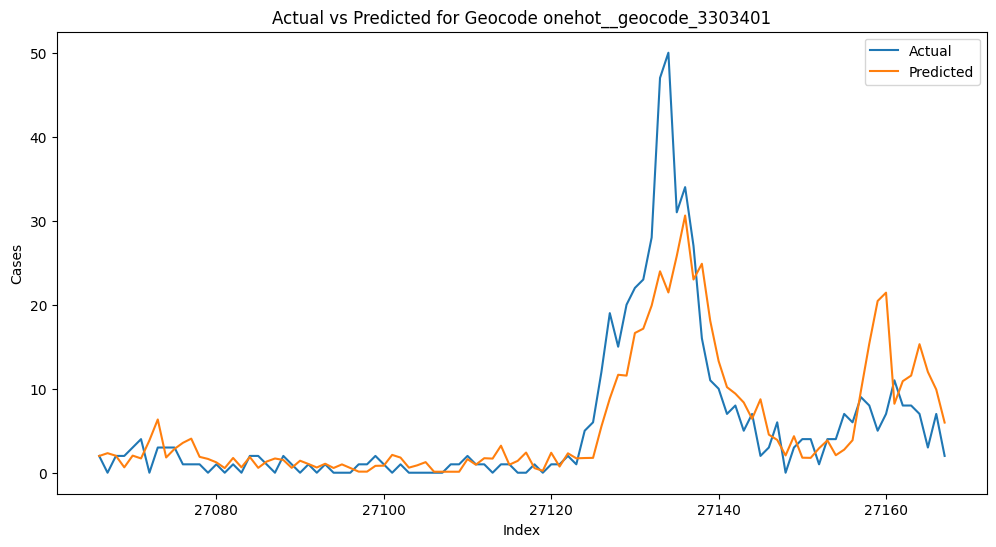

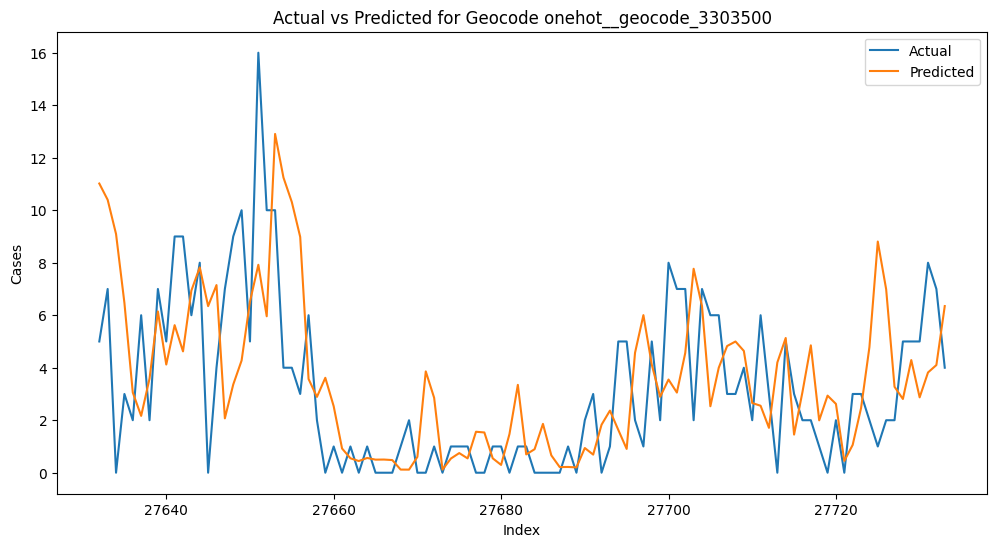

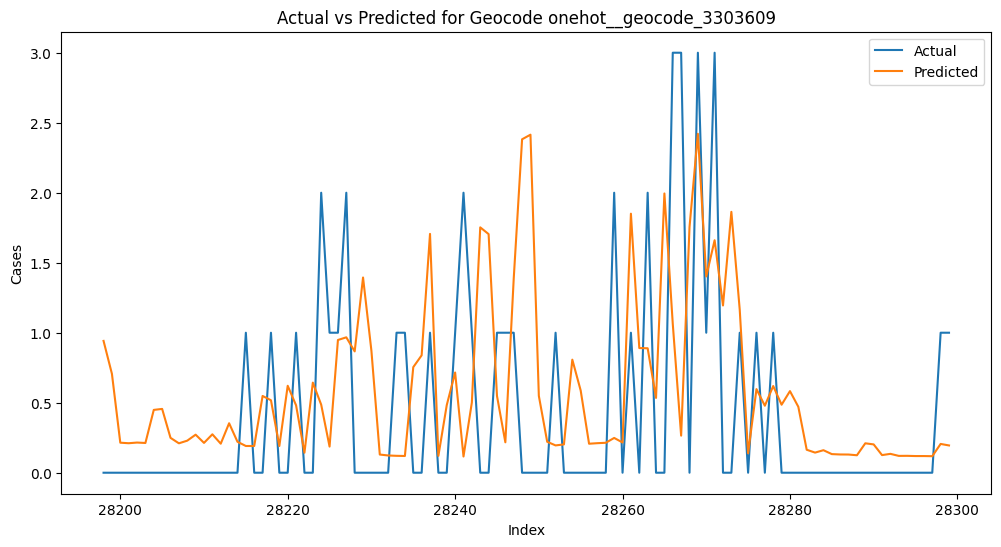

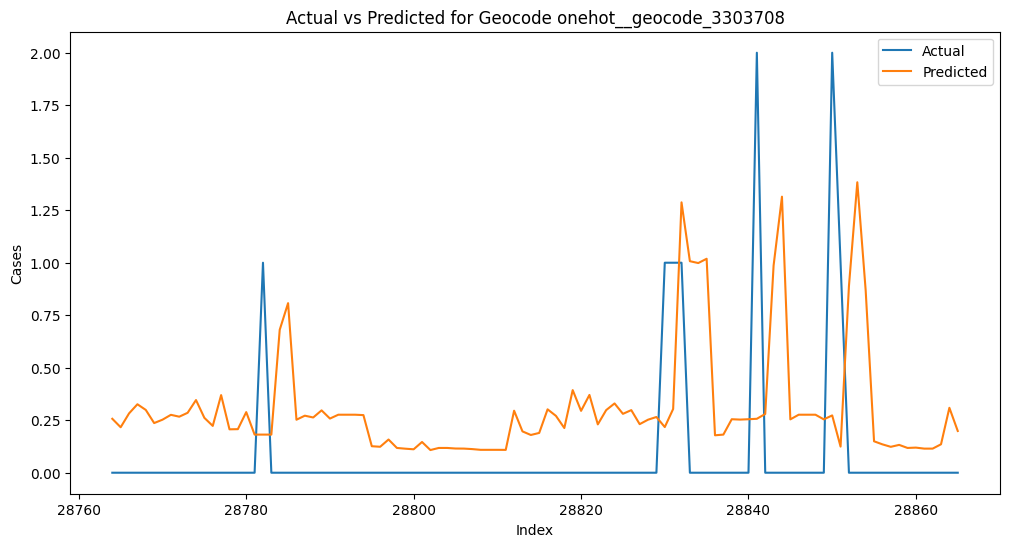

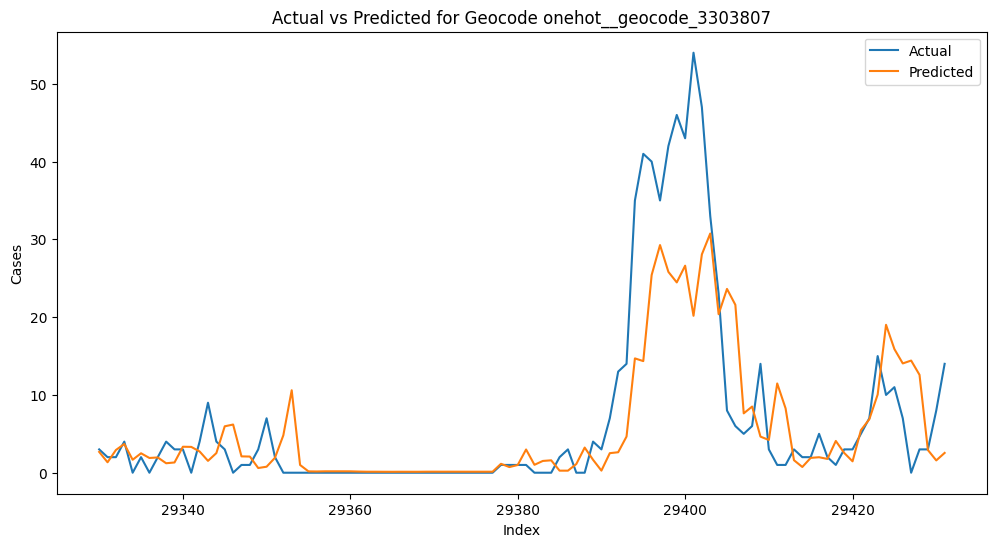

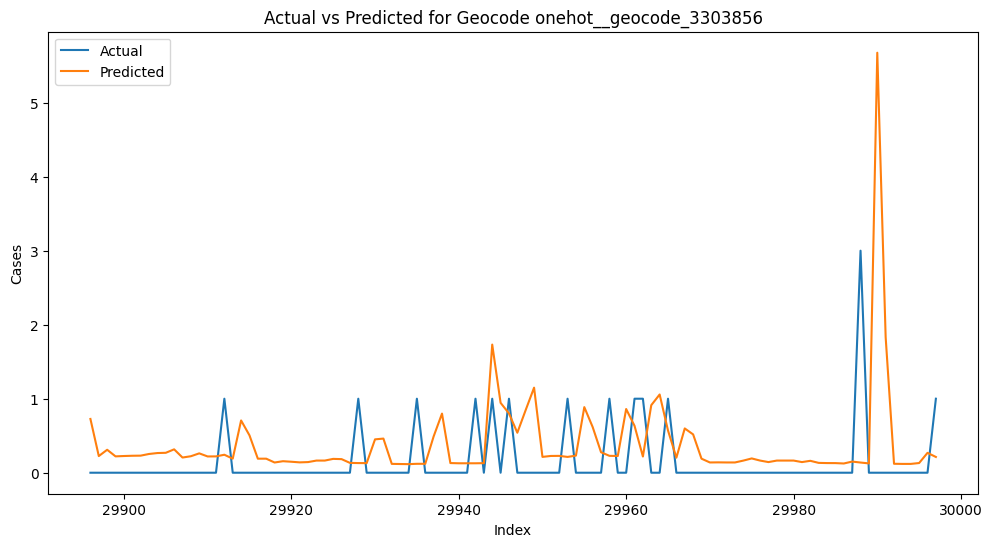

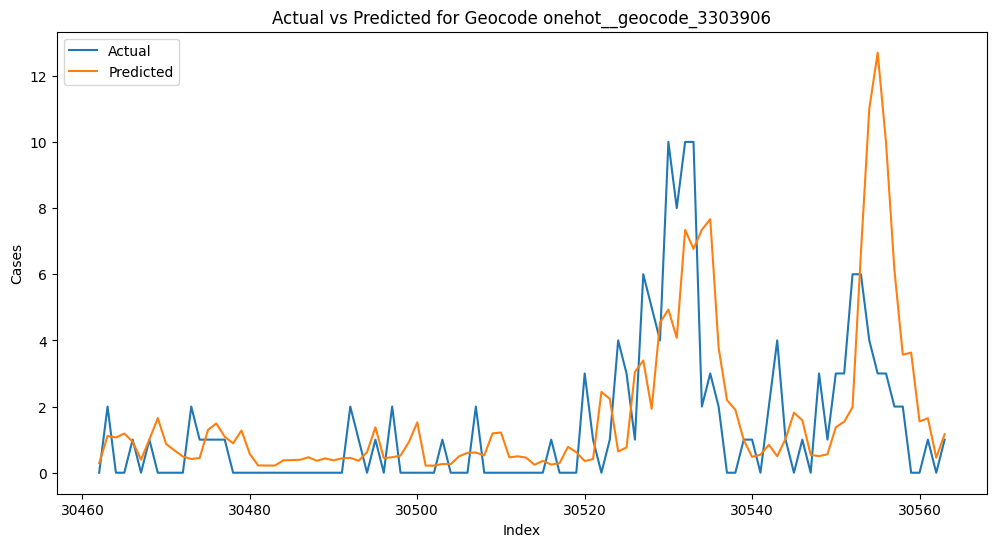

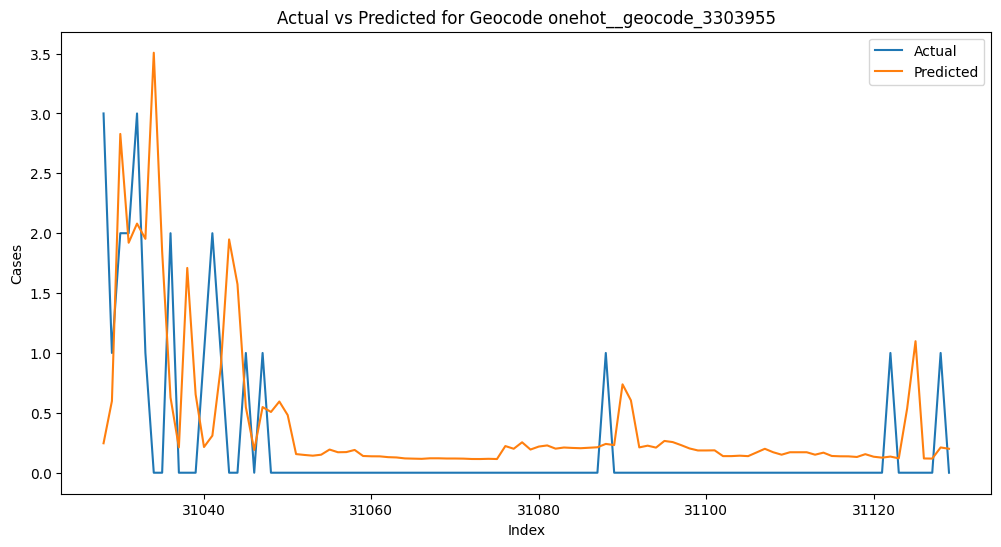

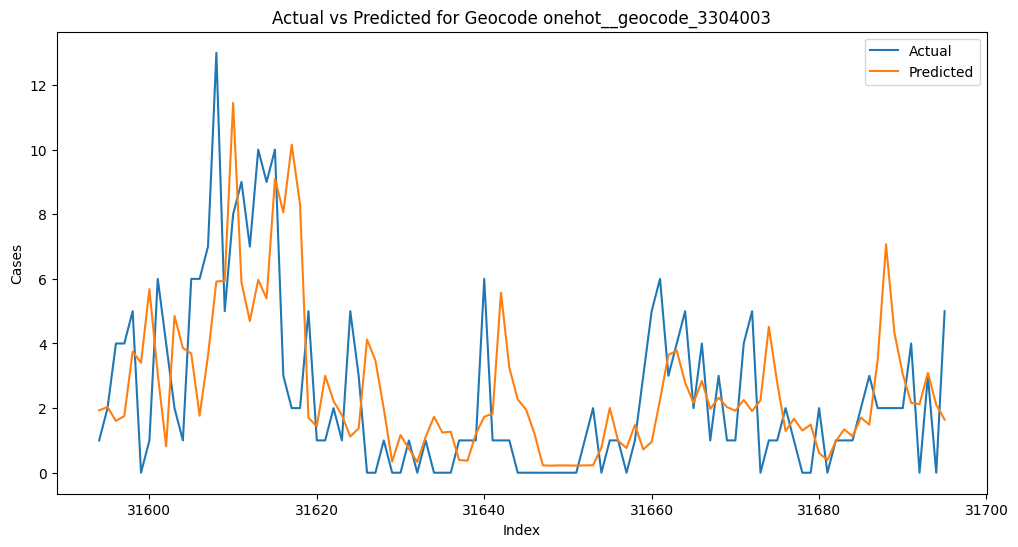

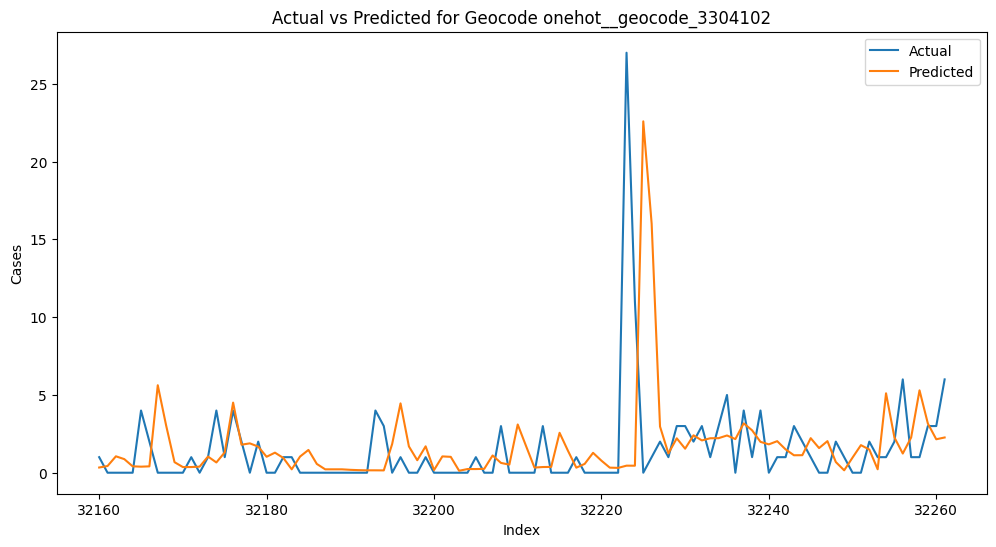

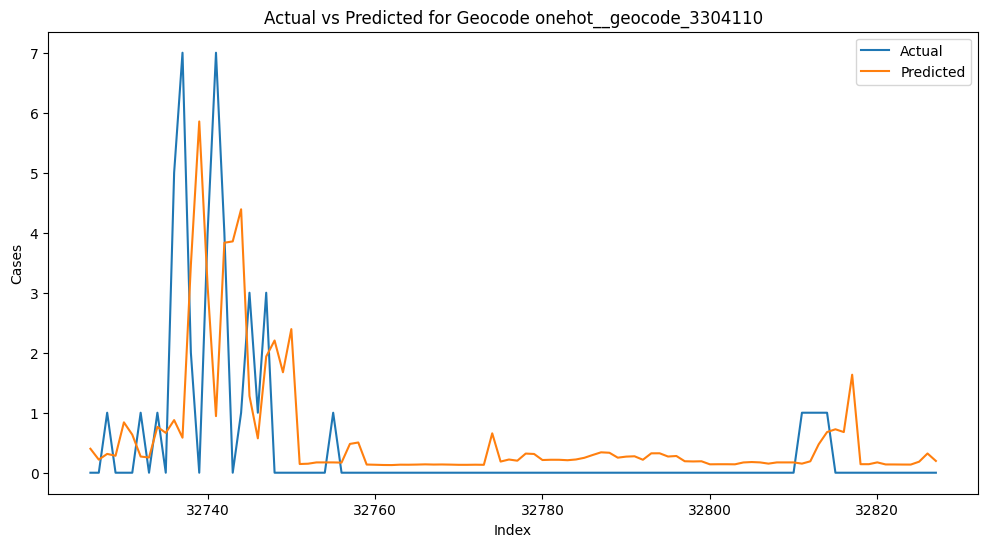

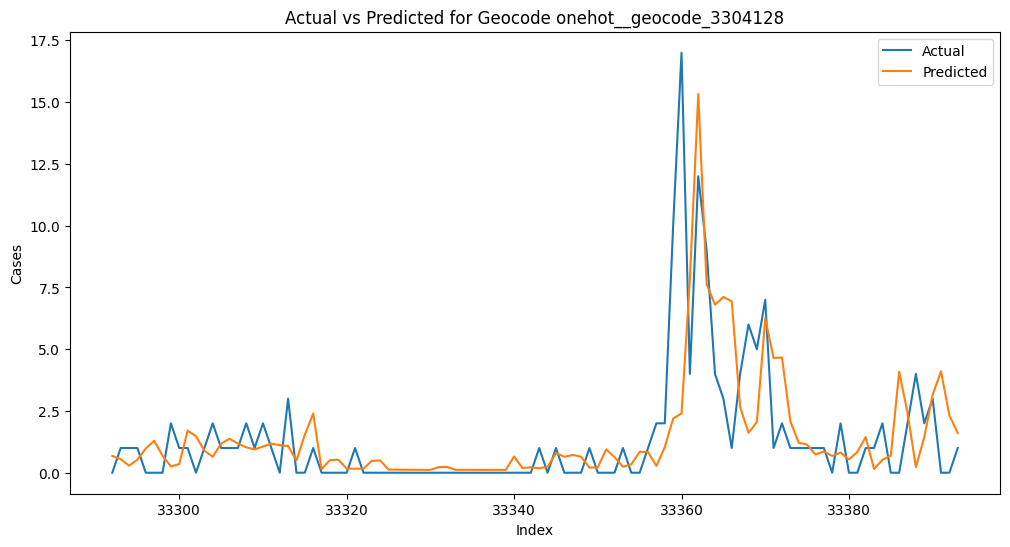

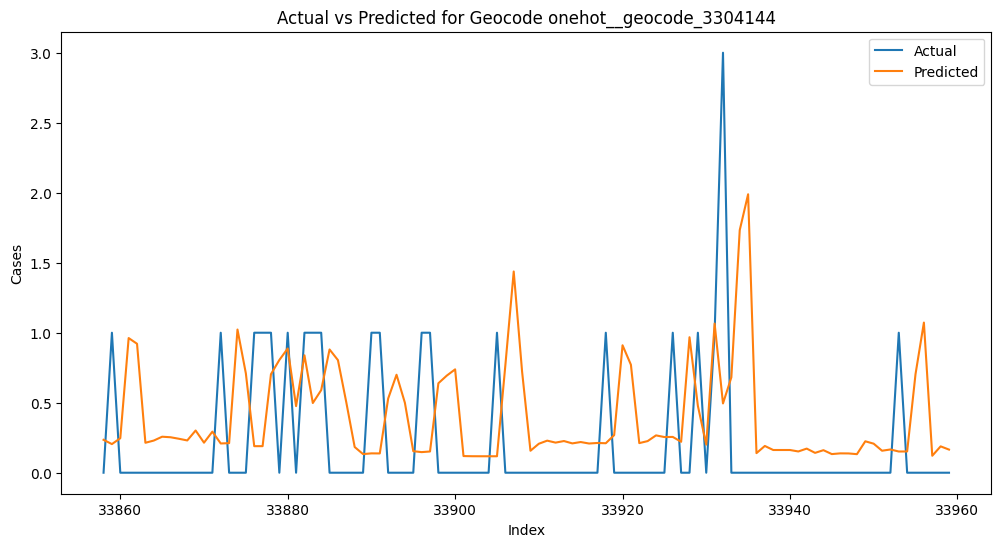

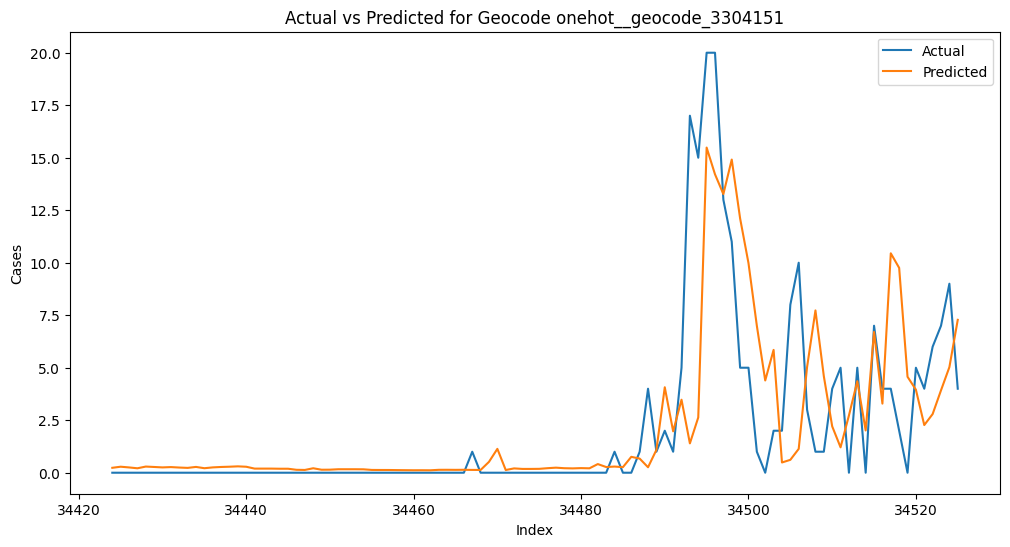

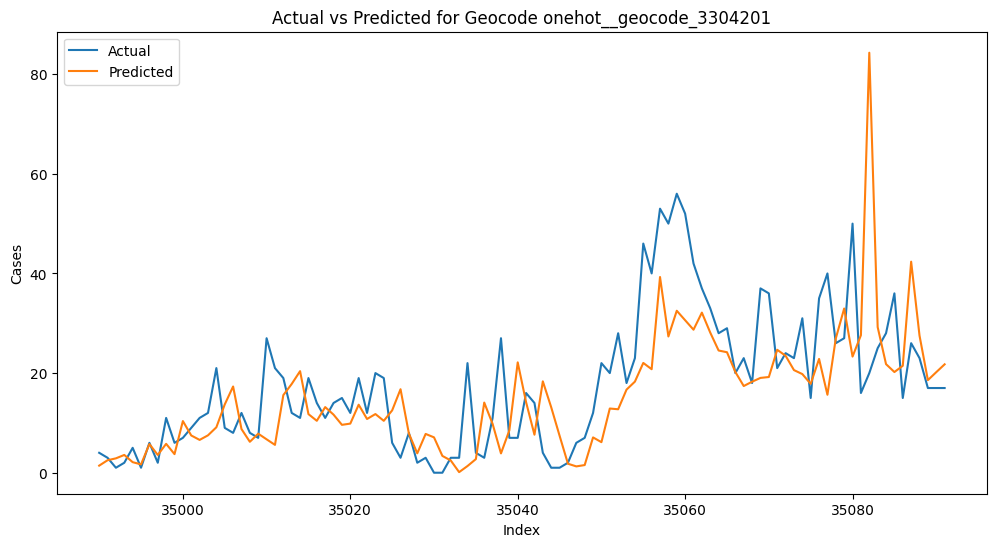

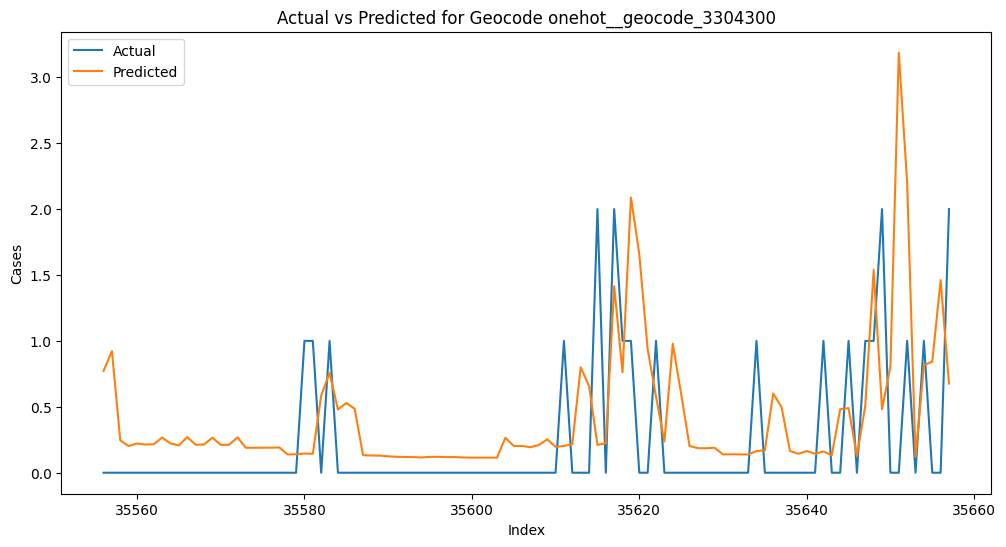

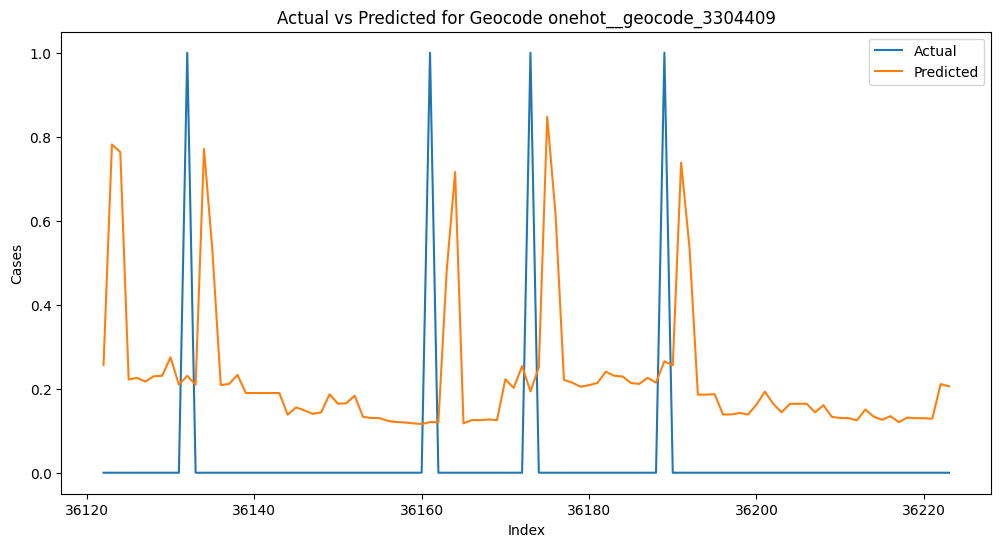

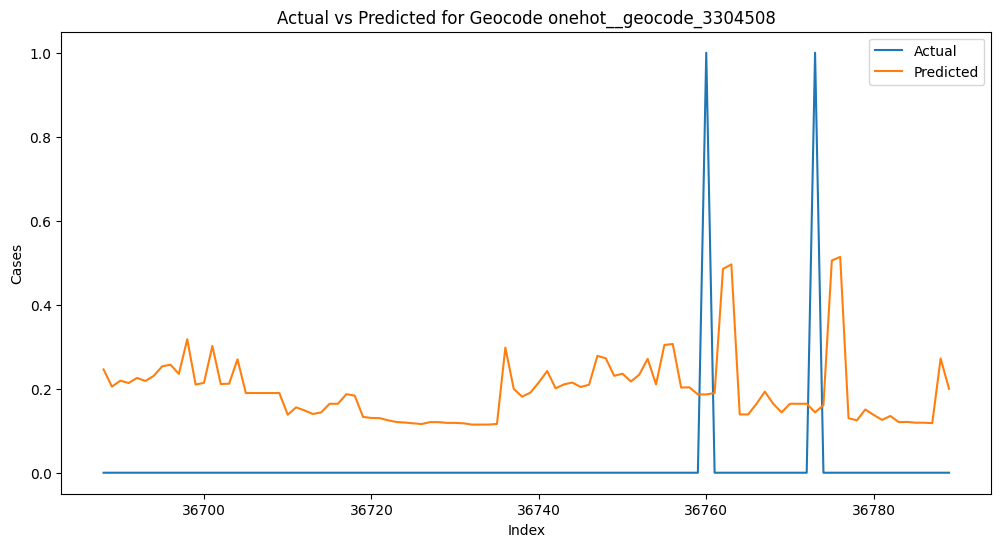

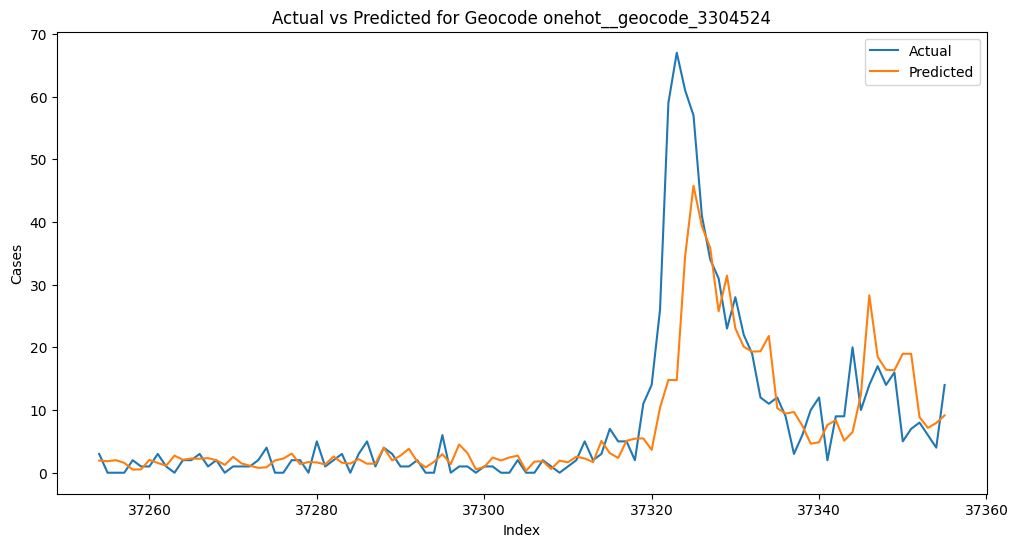

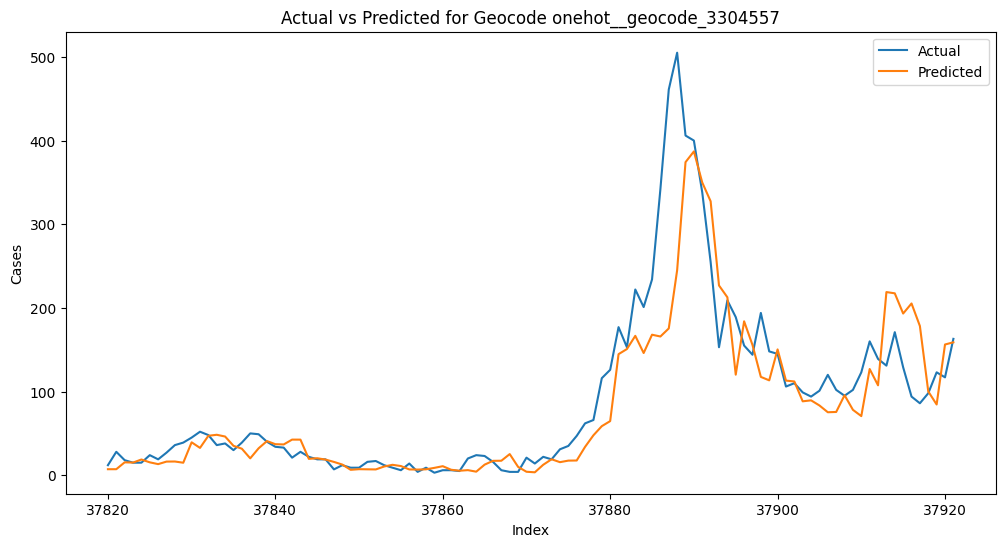

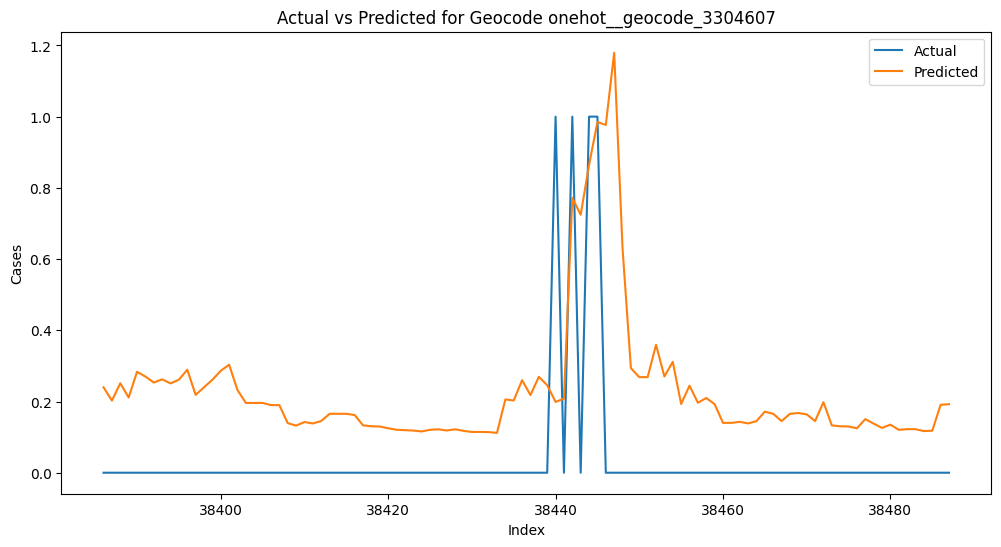

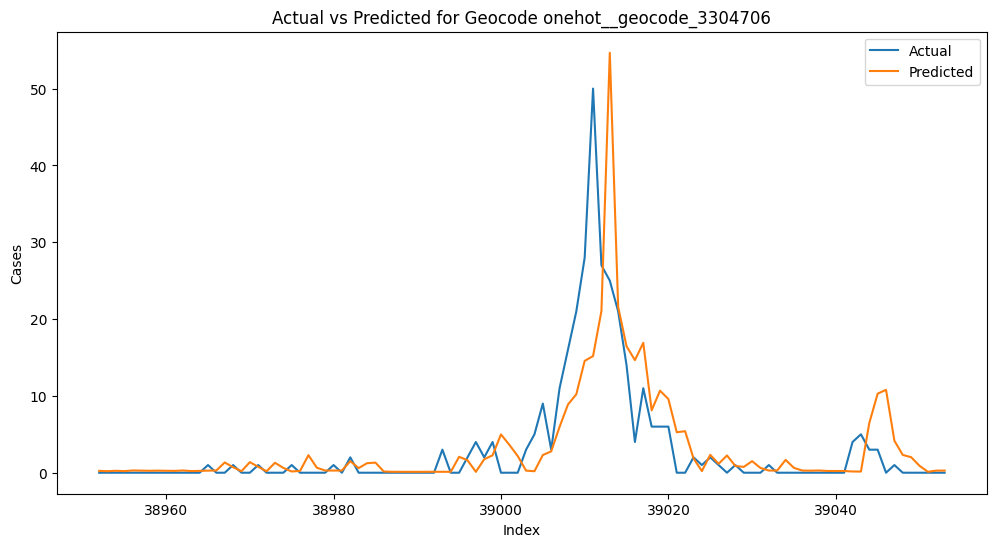

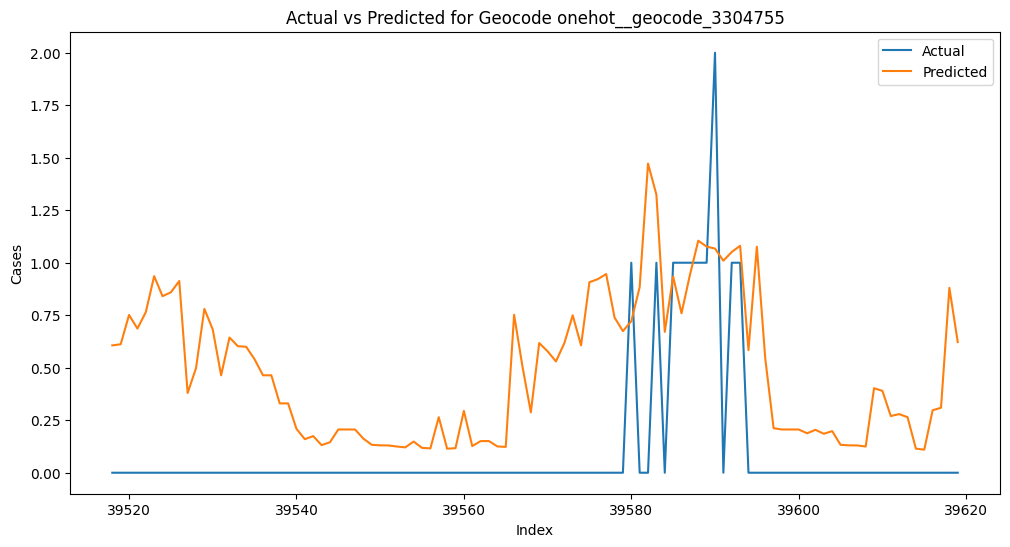

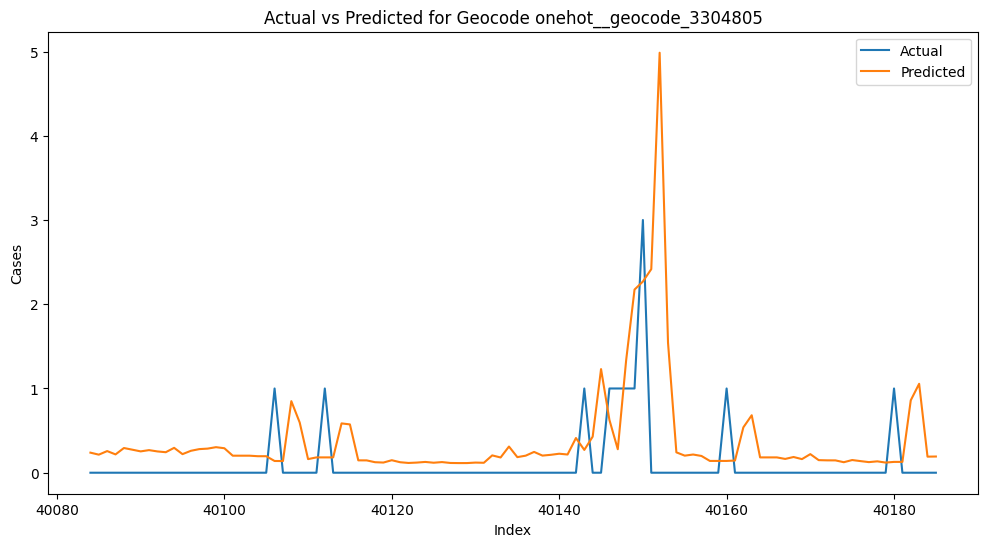

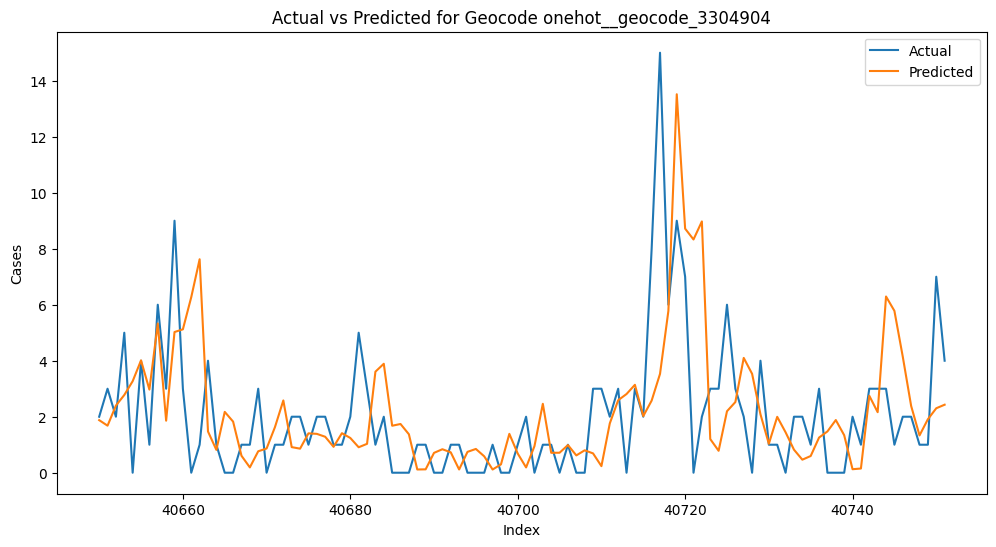

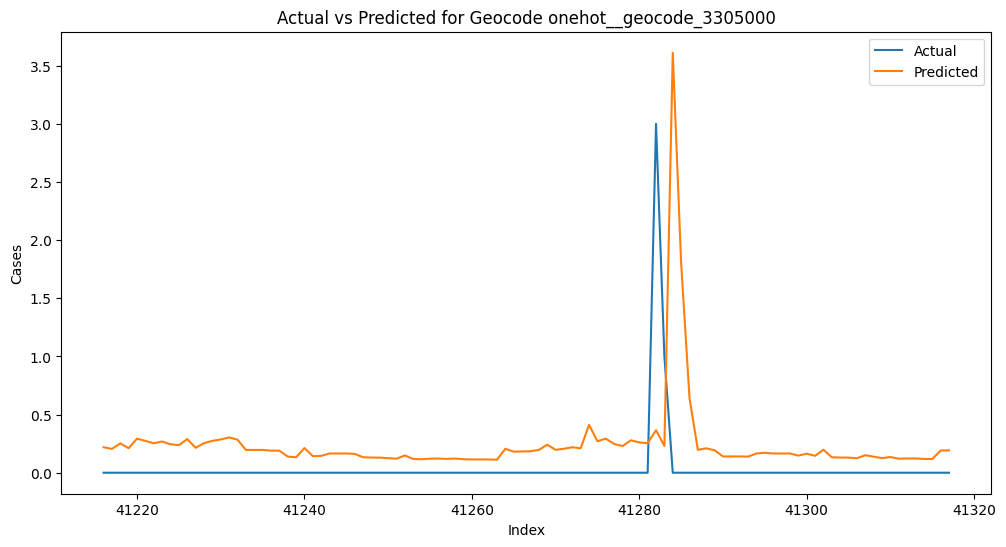

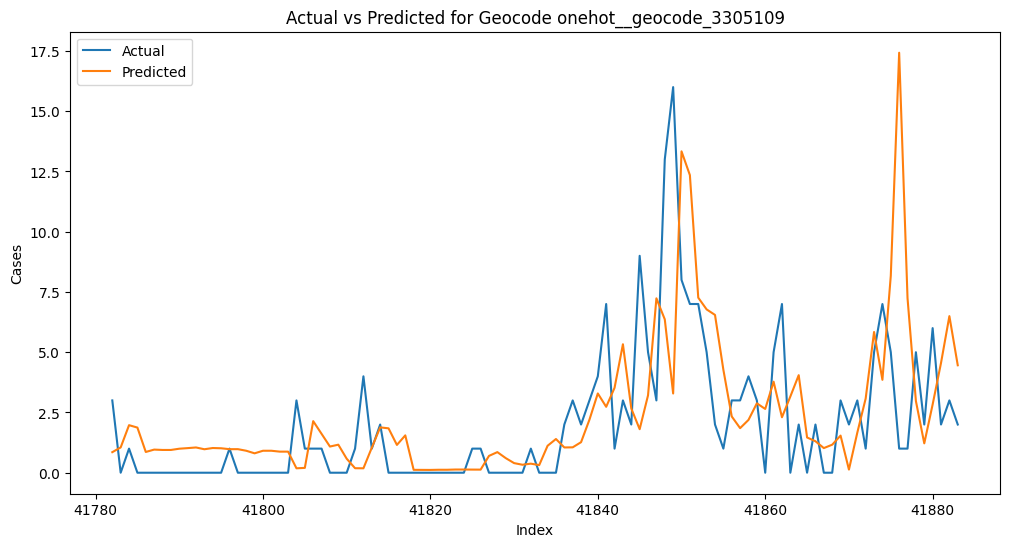

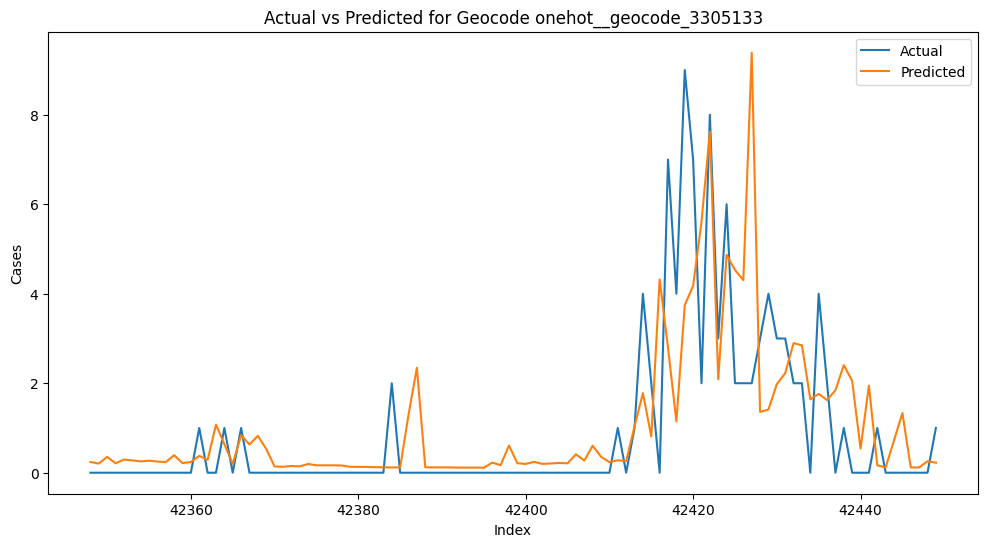

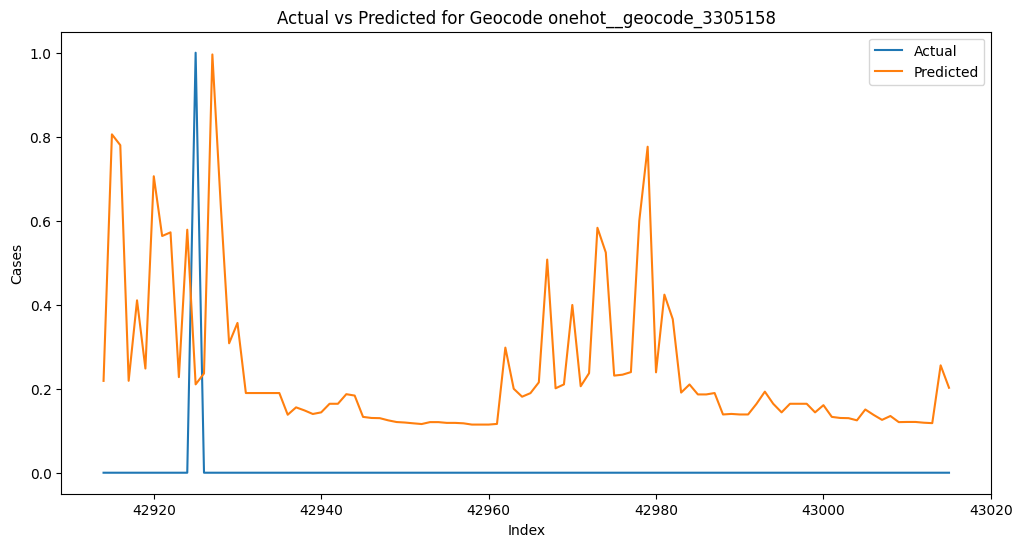

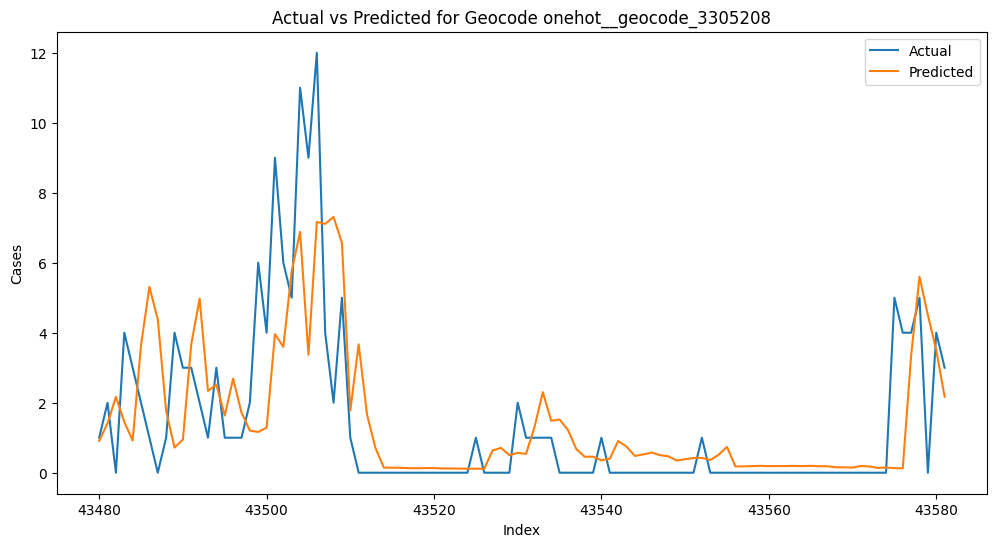

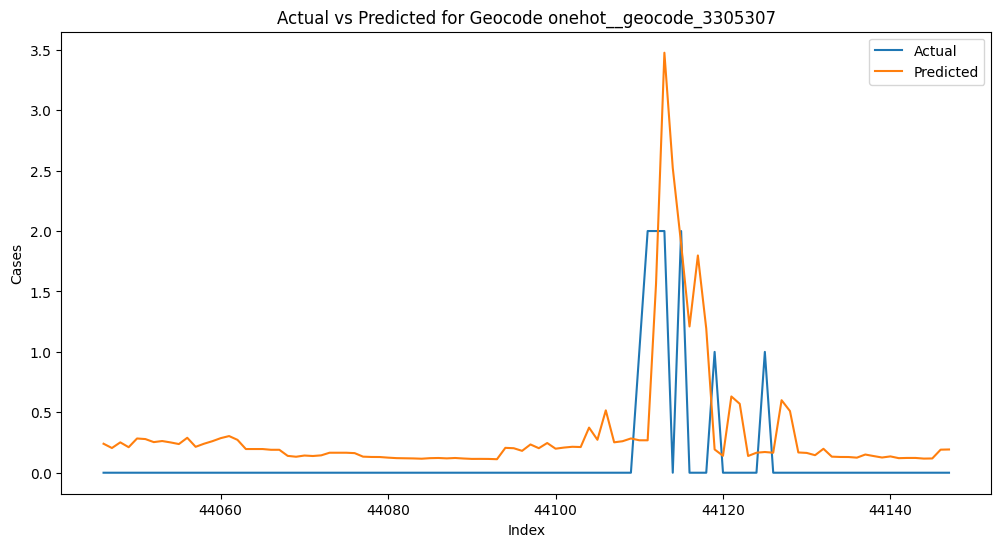

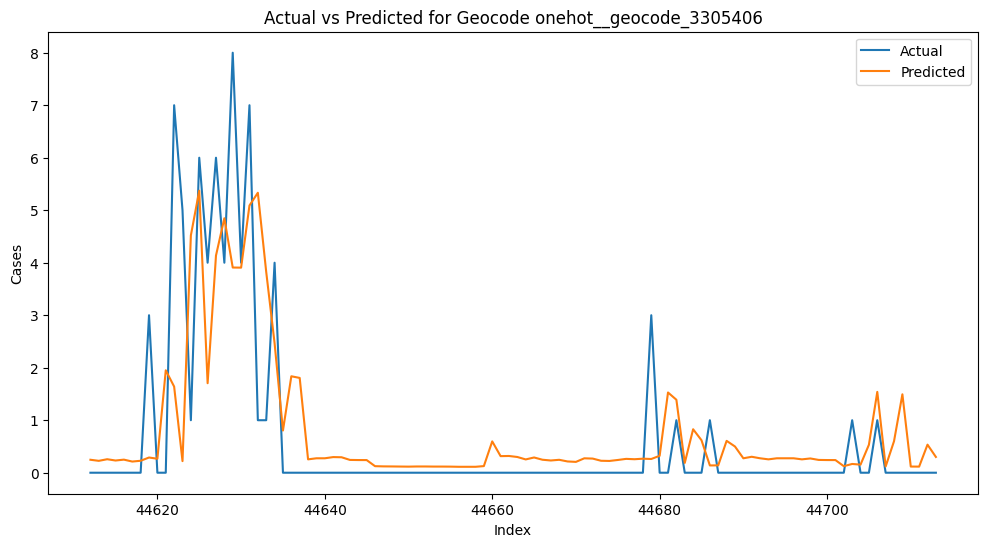

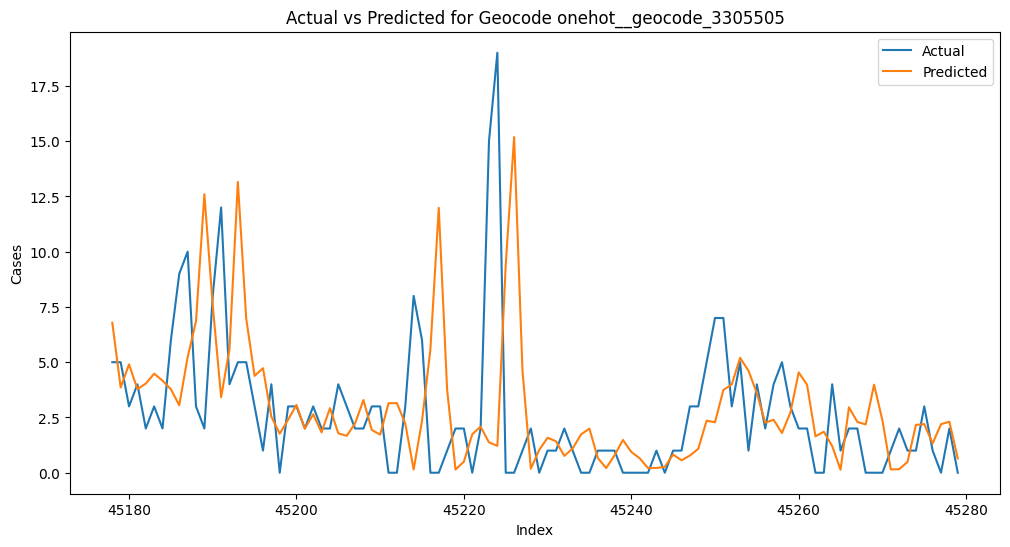

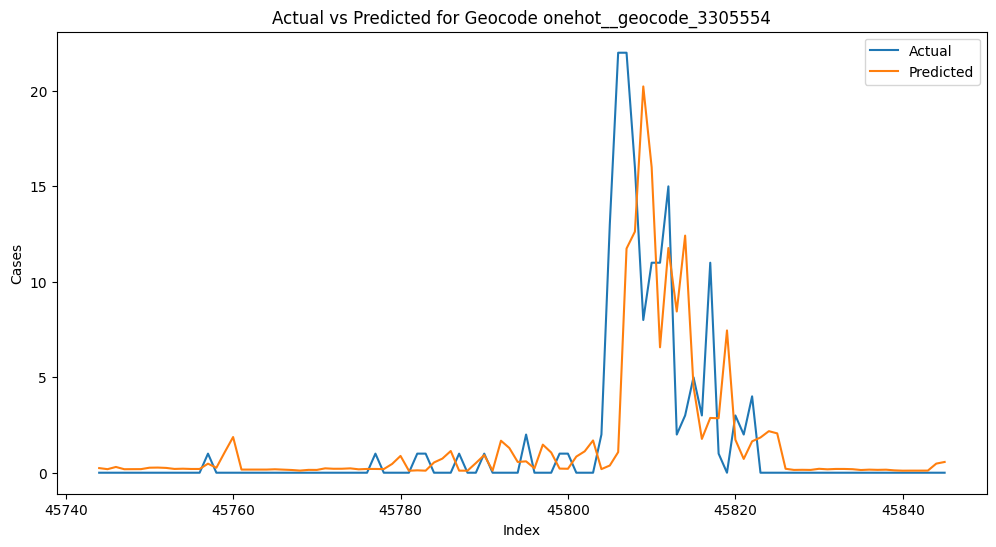

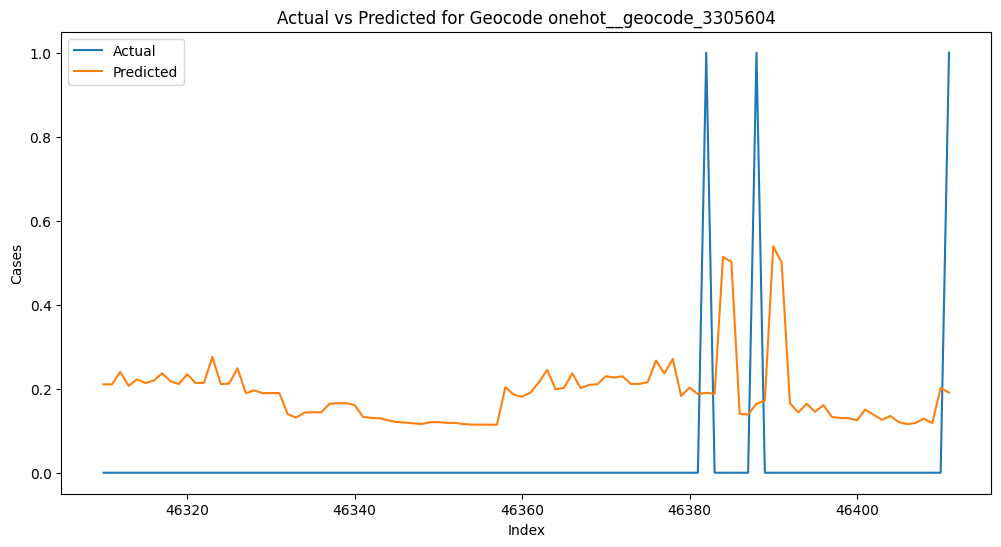

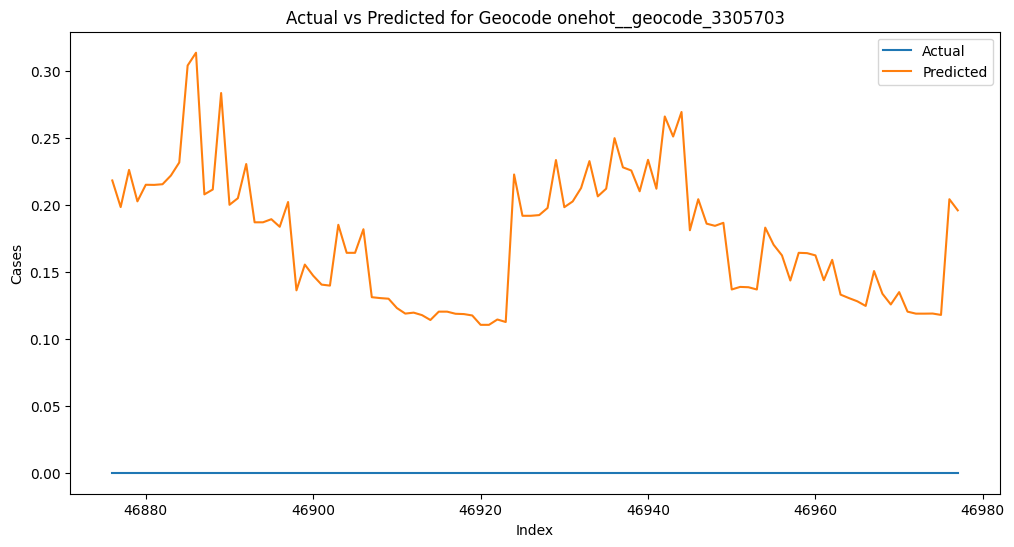

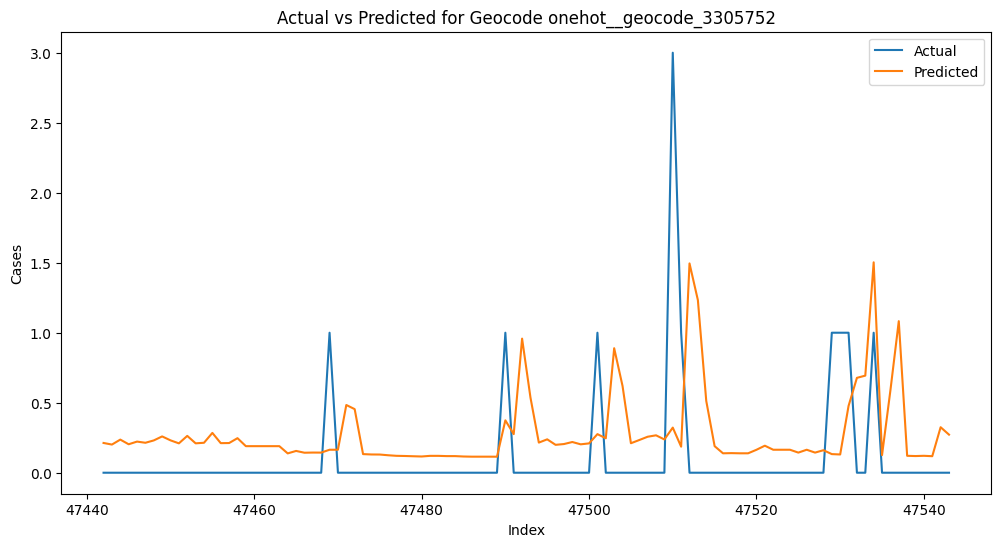

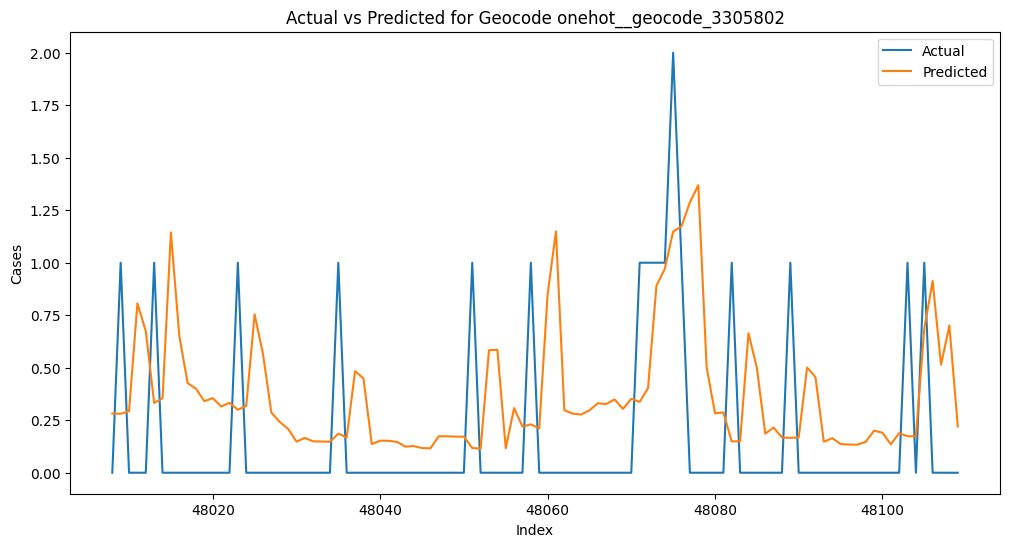

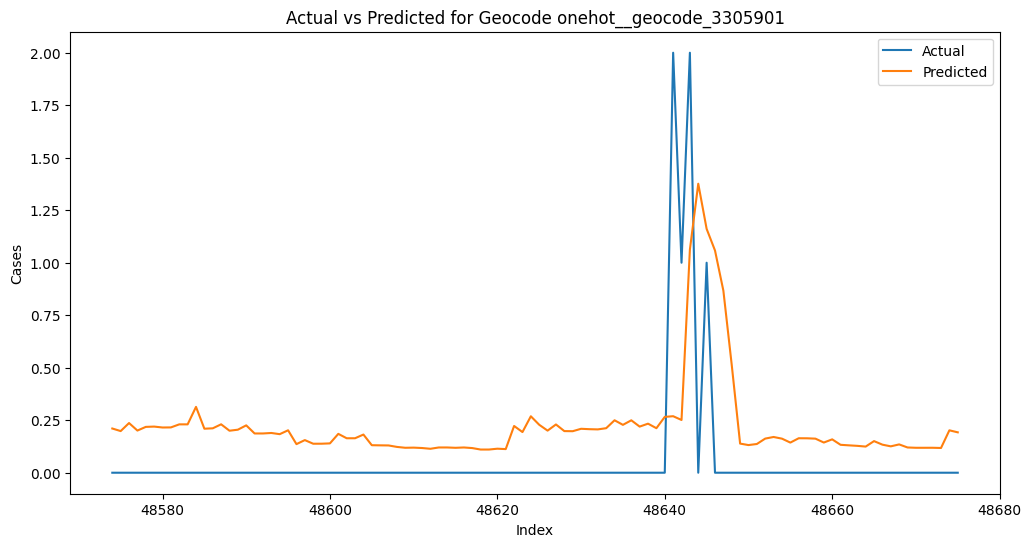

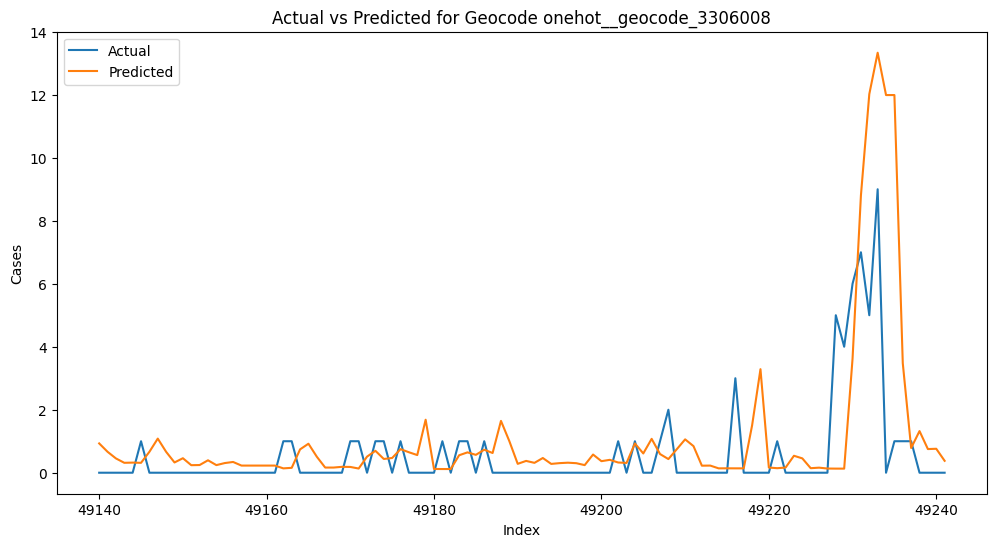

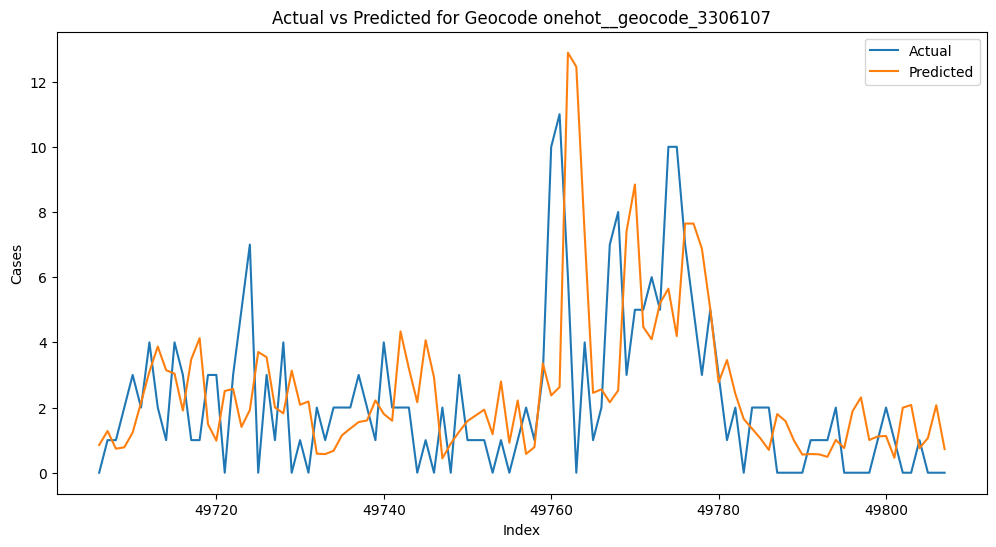

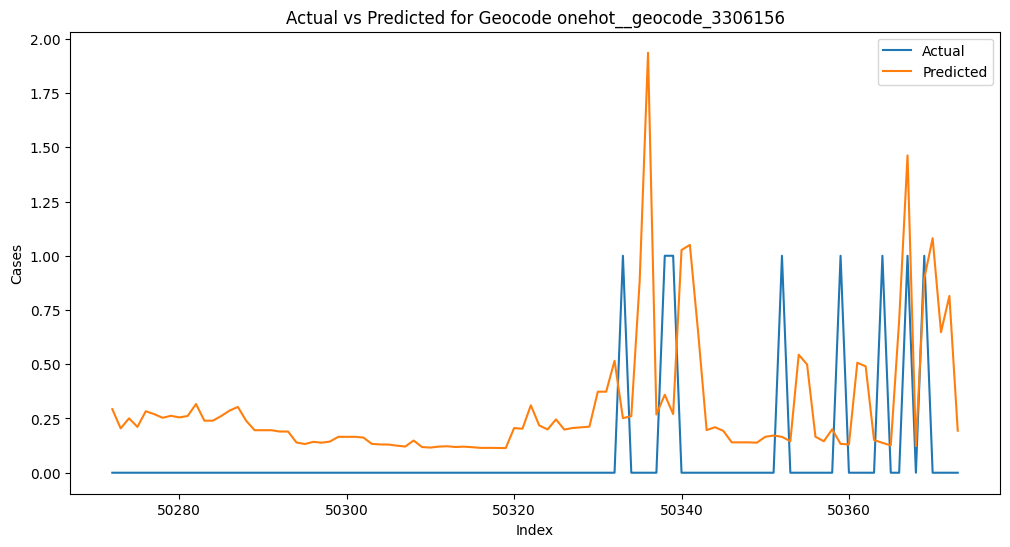

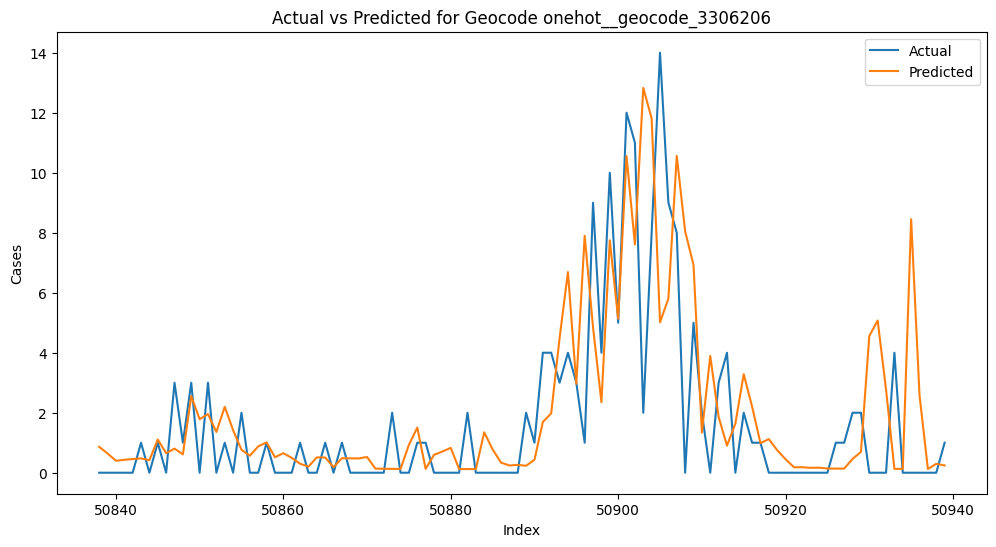

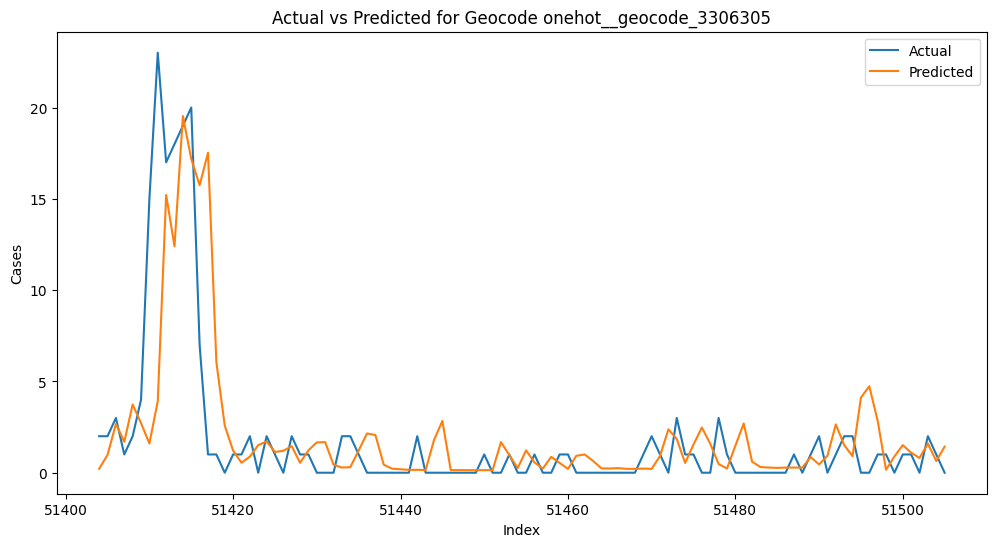

In [6]:
# Define parameter grid for Random Forest
grid_params = {
    'n_estimators': [50],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, grid_params, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train_scaled)

best_model = grid_search.best_estimator_

# Predictions
y_train_pred_scaled = best_model.predict(X_train)
y_test_pred_scaled = best_model.predict(X_test)

y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_train_original = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
train_r2 = r2_score(y_train_original, y_train_pred)
test_r2 = r2_score(y_test_original, y_test_pred)

mae = mean_absolute_error(y_test_original, y_test_pred)
mape = mean_absolute_percentage_error(y_test_original, y_test_pred)

# Print best parameters and metrics
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R²:", train_r2)
print("Test R²:", test_r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100, "%")

# Feature Importance
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Prepare test dataframe with results
X_test_df = pd.DataFrame(X_test, columns=selected_columns)
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_test_pred

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):
        subset = X_test_df[X_test_df[geocode] == 1]
        plt.figure(figsize=(12, 6))
        plt.plot(subset.index, subset["actual"], label='Actual')
        plt.plot(subset.index, subset["predicted"], label='Predicted')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()


In [7]:
# Make a copy of the test DataFrame
X_test_full = X_test.copy()

# --- Step 1: Reconstruct geocode from one-hot encoded columns
geocode_cols = [col for col in X_test_full.columns if col.startswith("onehot__geocode_")]

# Extract the geocode number from the column name where the value is 1
def extract_geocode(row):
    for col in geocode_cols:
        if row[col] == 1:
            return col.split("_")[-1]  # Gets '3300100' from 'onehot__geocode_3300100'
    return None
X_test_full['geocode'] = X_test_full[geocode_cols].apply(extract_geocode, axis=1)
# Drop all onehot columns
onehot_cols = [col for col in X_test_full.columns if col.startswith("onehot")]
X_test_full.drop(columns=onehot_cols, inplace=True)

X_test_full

cases_lag0  cases_lag1  temp_avg_lag4  humidity_avg_lag4  \
464      0.000068    0.000000       0.641592           0.260158   
465      0.000000    0.000068       0.681853           0.215388   
466      0.000000    0.000000       0.609745           0.287986   
467      0.000000    0.000000       0.627714           0.275856   
468      0.000068    0.000000       0.751505           0.202532   
...           ...         ...            ...                ...   
51501    0.000000    0.000068       0.650033           0.268028   
51502    0.000068    0.000000       0.677784           0.243861   
51503    0.000068    0.000068       0.559601           0.274196   
51504    0.000000    0.000068       0.555001           0.292489   
51505    0.000136    0.000000       0.646176           0.252885   

       precipitation_max_regression_kriging_lag4  week_sin     month_sin  \
464                                     0.348473 -0.354605  5.000000e-01   
465                                     0.171348 -0.464723  5.000000e-01   
466                                     0.506731 -0.568065  5.000000e-01   
467                                     0.279935 -0.663123  5.000000e-01   
468                                     0.228346 -0.748511  5.000000e-01   
...                                          ...       ...           ...   
51501                                   0.096761  0.822984 -5.000000e-01   
51502                                   0.143022  0.748511 -5.000000e-01   
51503                                   0.174420  0.663123 -5.000000e-01   
51504                                   0.252330  0.568065 -2.449294e-16   
51505                                   0.152204  0.464723 -2.449294e-16   

       week_cos  month_cos      year_sin  year_cos    week  geocode  
464   -0.935016   0.866025 -3.107406e-03  0.999995  202101  3300100  
465   -0.885456   0.866025 -3.107406e-03  0.999995  202102  3300100  
466   -0.822984   0.866025 -3.107406e-03  0.999995  202103  3300100  
467   -0.748511   0.866025 -3.107406e-03  0.999995  202104  3300100  
468   -0.663123   0.866025 -3.107406e-03  0.999995  202105  3300100  
...         ...        ...           ...       ...     ...      ...  
51501 -0.568065   0.866025 -2.449294e-16  1.000000  202246  3306305  
51502 -0.663123   0.866025 -2.449294e-16  1.000000  202247  3306305  
51503 -0.748511   0.866025 -2.449294e-16  1.000000  202248  3306305  
51504 -0.822984   1.000000 -2.449294e-16  1.000000  202249  3306305  
51505 -0.885456   1.000000 -2.449294e-16  1.000000  202250  3306305  

[9282 rows x 13 columns]

In [8]:
X_test_full['year'] = X_test_full['week'].astype(str).str[:4].astype(int)
X_test_full

cases_lag0  cases_lag1  temp_avg_lag4  humidity_avg_lag4  \
464      0.000068    0.000000       0.641592           0.260158   
465      0.000000    0.000068       0.681853           0.215388   
466      0.000000    0.000000       0.609745           0.287986   
467      0.000000    0.000000       0.627714           0.275856   
468      0.000068    0.000000       0.751505           0.202532   
...           ...         ...            ...                ...   
51501    0.000000    0.000068       0.650033           0.268028   
51502    0.000068    0.000000       0.677784           0.243861   
51503    0.000068    0.000068       0.559601           0.274196   
51504    0.000000    0.000068       0.555001           0.292489   
51505    0.000136    0.000000       0.646176           0.252885   

       precipitation_max_regression_kriging_lag4  week_sin     month_sin  \
464                                     0.348473 -0.354605  5.000000e-01   
465                                     0.171348 -0.464723  5.000000e-01   
466                                     0.506731 -0.568065  5.000000e-01   
467                                     0.279935 -0.663123  5.000000e-01   
468                                     0.228346 -0.748511  5.000000e-01   
...                                          ...       ...           ...   
51501                                   0.096761  0.822984 -5.000000e-01   
51502                                   0.143022  0.748511 -5.000000e-01   
51503                                   0.174420  0.663123 -5.000000e-01   
51504                                   0.252330  0.568065 -2.449294e-16   
51505                                   0.152204  0.464723 -2.449294e-16   

       week_cos  month_cos      year_sin  year_cos    week  geocode  year  
464   -0.935016   0.866025 -3.107406e-03  0.999995  202101  3300100  2021  
465   -0.885456   0.866025 -3.107406e-03  0.999995  202102  3300100  2021  
466   -0.822984   0.866025 -3.107406e-03  0.999995  202103  3300100  2021  
467   -0.748511   0.866025 -3.107406e-03  0.999995  202104  3300100  2021  
468   -0.663123   0.866025 -3.107406e-03  0.999995  202105  3300100  2021  
...         ...        ...           ...       ...     ...      ...   ...  
51501 -0.568065   0.866025 -2.449294e-16  1.000000  202246  3306305  2022  
51502 -0.663123   0.866025 -2.449294e-16  1.000000  202247  3306305  2022  
51503 -0.748511   0.866025 -2.449294e-16  1.000000  202248  3306305  2022  
51504 -0.822984   1.000000 -2.449294e-16  1.000000  202249  3306305  2022  
51505 -0.885456   1.000000 -2.449294e-16  1.000000  202250  3306305  2022  

[9282 rows x 14 columns]

In [ ]:

# Add actual and predicted values
X_test_full['actual'] = y_test_original
X_test_full['rf_pred'] = y_test_pred

# Export predictions by year
rf_preds_2021 = X_test_full[X_test_full['year'] == 2021][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2021.to_csv('../base_predictions/rf_preds.csv', index=False)

rf_preds_2022 = X_test_full[X_test_full['year'] == 2022][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2022.to_csv('../base_predictions/rf_test_preds.csv', index=False)